In [78]:
import numpy as np
import pandas as pd
import os
from content_moderation_model import StrategicUser
from content_moderation_data_code import generate_ratings_data, run_main
from random_simulation import RatingSimulation
from grid_simulation import RatingGridSimulation

from content_moderation_assessment import factorization_results, plot_factorization_results, plot_distance_results, plot_user_location, get_exp_diff

from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
from tqdm.auto import tqdm
import json
import dill

np.random.seed(0)

import content_moderation_constants as C
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'monospace'
title_font = {
    'style': 'italic',
    'weight': 'heavy',
    'size': 14
}

colors = {'H': '#6ea658', "S": "#f5d742", 'N': '#db4444', "ALL": "#757575"}

In [ ]:
dill.dump_session('last_session.db')

In [2]:
dill.load_session('last_session.db')

* Number of simulated ratings: 313125
count    501.000000
mean     625.000000
std       20.847062
min      551.000000
25%      611.000000
50%      625.000000
75%      638.000000
max      689.000000
Name: note_sim_ID, dtype: float64
* Number of assigned ratings to strategic user 625


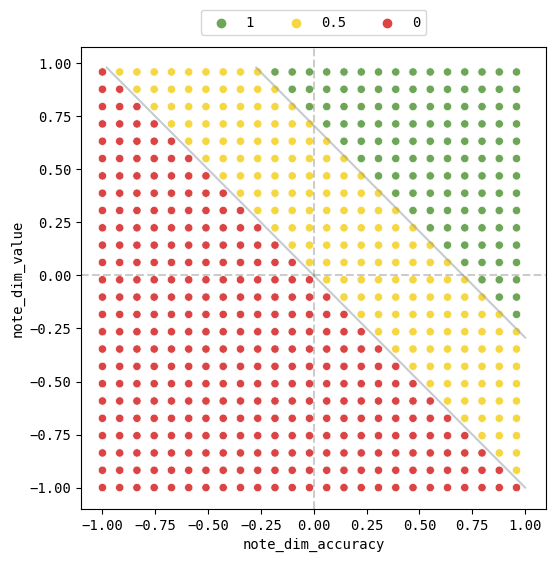

In [98]:
configs = {
    "user_n": 500,
    "user_pi_R": 1/2,
    "note_grid_n": 50,
    "init_all": True,
}

U = StrategicUser(sim_id=configs['user_n'])
GridSim = RatingGridSimulation(configs, strategic_users=[U])

a = GridSim.assign_raters_frac(dim_frac=0.5, strategic_user_grid=True)
a['rating'] = a['evaluation']
print("* Number of simulated ratings:", len(a))
print(a.groupby("user_sim_ID")["note_sim_ID"].nunique().describe())

point_experiment_index = np.where(a['user_sim_ID'] == U.sim_id)[0]

U_a = a.iloc[point_experiment_index,:]
print("* Number of assigned ratings to strategic user", len(U_a))

plt.figure(figsize=(6,6))

colors = {1: '#6ea658', 0.5: "#f5d742", 0: '#db4444', "ALL": "#757575"}

note_scatter = sns.scatterplot(
    U_a, x="note_dim_accuracy", y="note_dim_value", hue="evaluation", 
    hue_order=[1, 0.5, 0], palette=colors)
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

thresh_color = "#8c98a3"
for t in [0, 0.5]:
    x = np.linspace(-1, 1, 100)
    y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
    mask = (y <= 1)

    sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5)

note_scatter.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), borderaxespad=0., ncols=3)

plt.show()

In [99]:
ratings_list = [1, 0.5, 0]
ratings_dict = {
    1: "H", 
    0.5: "S", 
    0: "N", 
    }

a_H = a.loc[point_experiment_index]
a_H['rating'] = 1
a_S = a.loc[point_experiment_index]
a_S['rating'] = 0.5
a_N = a.loc[point_experiment_index]
a_N['rating'] = 0
l_ratings = [a, a_H, a_S, a_N]
rating_input_df = generate_ratings_data(pd.concat(l_ratings), GridSim, return_data = True)
input_df_dict = {
    'baseline': rating_input_df.iloc[:len(a),:],
    1: rating_input_df.iloc[len(a):len(a) + len(a_H),:],
    0.5: rating_input_df.iloc[len(a) + len(a_H):len(a) + len(a_H) + len(a_S),:],
    0: rating_input_df.iloc[len(a) + len(a_H) + len(a_S):,:],
}
filenames = {"baseline": os.path.join(C.grid_exp_data_path, "baseline.tsv")}
input_df_dict['baseline'].to_csv(filenames["baseline"], sep="\t", index=False)

for r in ratings_list:
    this_rating = a.copy()
    this_rating.loc[point_experiment_index, 'rating'] = r
    for enum, idx in tqdm(enumerate(point_experiment_index), total=len(point_experiment_index)):
        exp_eval = this_rating.iloc[idx]['evaluation']
        if r != exp_eval:
            exp_note_ID = this_rating.iloc[idx]['note_sim_ID'].astype(int)
            experiment_name = f"e_{exp_note_ID}_{ratings_dict[exp_eval]}_{ratings_dict[r]}"
            filename = os.path.join(C.grid_exp_data_path, f"{experiment_name}.tsv")
            filenames[experiment_name] = filename

            input_df = input_df_dict['baseline'].copy()
            input_df.loc[idx, :] = input_df_dict[r].iloc[enum, :]
            input_df.to_csv(filename, sep="\t", index=False)

json.dump(filenames, open(os.path.join(C.grid_exp_data_path, "last_exp_file_names.json"), "w"))

Loading ratings and id map data...
Sampling explanation tags...


  0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
filenames = json.load(open(os.path.join(C.grid_exp_data_path, "last_exp_file_names.json"), "r"))

In [4]:
note_output = {}
user_output = {}
with ProcessPoolExecutor(
    mp_context=mp.get_context("spawn")
) as executor:
    futures = [
        executor.submit(run_main, ratings_path = ratings_path, return_data = True, logging = False, simulation_model = GridSim) for ratings_path in list(filenames.values())
        ]
    for f in tqdm(as_completed(futures), total=len(futures)):
        output = f.result()
        exp_name = output[0]
        note_output[exp_name] = output[1]
        user_output[exp_name] = output[2]
        note_fn = os.path.join(C.grid_exp_data_path, f"{exp_name}_result_note.pkl")
        user_fn = os.path.join(C.grid_exp_data_path, f"{exp_name}_result_user.pkl")
        output[1].to_pickle(note_fn)
        output[2].to_pickle(user_fn)

  0%|          | 0/339 [00:00<?, ?it/s]

------------------
Users: 501, Notes: 2500
------------------
Users: 501, Notes: 2500
------------------
Users: 501, Notes: 2500
------------------
Users: 501, Notes: 2500
------------------
Users: 501, Notes: 2500
mps
------------------
Users: 501, Notes: 2500
------------------
Users: 501, Notes: 2500
mps
------------------
Users: 501, Notes: 2500
mps
mps
mps
mps
mps
mps
Num epochs: 121
Global Intercept:  0.11655208468437195
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 121
Global Intercept:  0.11654850840568542
Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Num epochs: 121
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Global Intercept:  0.11655212938785553
Applying scoring rule: NmCRNH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: In

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Num epochs: 101
Global Intercept:  0.11583276093006134
Global Intercept:  0.11583682894706726
Num epochs: 101
Global Intercept:  0.11583619564771652
Num epochs: 101
Global Intercept:  0.1158360093832016
Applying scoring rule: InitialNMR (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Global Intercept:  0.11583919078111649
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Global Intercept:  0.11583639681339264


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.18 seconds. Individual scorers: ['5.87'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.22 seconds. Individual scorers: ['6.16'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158364787697792
Num epochs: 101
Global Intercept:  0.11583810299634933
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.32 seconds. Individual scorers: ['5.16'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Total valid ratings: 12429
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.07 seconds. Individual scorers: ['4.97'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts:  501
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Total valid ratings: 12429
Applying scoring rule: Insuffici

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Total valid ratings: 12401
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Number Contributor Counts:  501
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12429
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12429
Num epochs: 101
Global Intercept:  0.11583761125802994
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Num epochs: 101
Applying scoring rule: CRHSuperThreshold (v1.0)
Global Intercept:  0.11583755910396576


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.63 seconds. Individual scorers: ['6.13'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.17 seconds. Individual scorers: ['6.17'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.14 seconds. Individual scorers: ['6.26'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Global Intercept:  0.1165556088089943
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12455
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Su

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Global Intercept:  0.1158364862203598


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11585067957639694
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158357709646225
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.85 seconds. Individual scorers: ['5.60'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Apply

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.29 seconds. Individual scorers: ['6.99'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.35 seconds. Individual scorers: ['7.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583637446165085
Num epochs: 121
Global Intercept:  0.11655191332101822
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Num epochs: 121
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Global Intercept:  0.11655048280954361
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12448
Num epochs: 121
Global Intercept:  0.11655180901288986
Total valid ratings: 12455
--------------

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.14 seconds. Individual scorers: ['7.26'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.28 seconds. Individual scorers: ['7.20'] seconds.
  

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH not

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.11583640426397324
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
Number Contributor Counts:  501
Num epochs: 101
Global Intercept:  0.11583641171455383
Num epochs: 101
Global Intercept:  0.11583682894706726
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.46 seconds. Individual scorers: ['6.29'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.64 seconds. Individual scorers: ['6.61'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-t

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583541333675385
Num epochs: 101
Global Intercept:  0.11583611369132996


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.91 seconds. Individual scorers: ['7.73'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: Scor

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11583622545003891
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Applying scoring rule: ScoringDriftGuard (v1.0)
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.37 seconds. Individual scorers: ['5.68'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Global Intercept:  0.1158507689833641
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (50

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Number Contributor Counts:  501
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.86 seconds. Individual scorers: ['7.21'] seconds.
  Run Counters (>1 if loss was too high, fo

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655192077159882
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583738774061203
----
  

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583621799945831
CRH / CRNH notes prior to filtering for insufficient explanation: 471
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.1158362627029419
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.47 seconds. Individual scorers: ['7.21'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12373
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Numb

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.62 seconds. Individual scorers: ['5.59'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12401
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.99 seconds. Individual scorers: ['6.44'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Ear

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.01 seconds. Individual scorers: ['7.13'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655064672231674
Num epochs: 101
Global Intercept:  0.11583530157804489
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12455
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655284464359283
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.27 seconds. Individual scorers: ['6.58'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583469808101654
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Enrollment State
Total valid ratings: 12429
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12429
Number Contributor Counts:  501
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.24 seconds. Individual scorers: ['5.85'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Number Contribu

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Applying scoring rule: NmCRNH (v1.0)
Total notes impacted by explanation filtering: 0
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158372163772583
Total valid ratings: 12402
Number Contributor Counts:  501
Total valid ratings: 12402


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11583510786294937
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.33 seconds. Individual scorers: ['6.88'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.76 seconds. Individual scorers: ['7.53']

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Num epochs: 101
Applying scoring rule: CRHSuperThreshold (v1.0)
Global Intercept:  0.11583658307790756
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Percentage of previous CRH flipping status: 0.0
Global Intercept:  0.11583631485700607
Num epochs: 120
Global Intercept:  0.11661291867494583
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 121
Global Intercept:  0.11655024439096451
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rul

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.04 seconds. Individual scorers: ['7.31'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583643406629562
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.80 seconds. Individual scorers: ['7.20'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDr

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.45 seconds. Individual scorers: ['7.15'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.11583678424358368
Total valid ratings: 12429
Number Contributor Counts:  501
Total valid ratings: 12429


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.87 seconds. Individual scorers: ['6.44'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583542823791504
Number Contributor Counts:  501
Num epochs: 101
Global Intercept:  0.1158345490694046
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.07 seconds. Individual scorers: ['6.88'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Num epochs: 121
Applying scoring rule: InitialNMR (v1.0)
Global Intercept:  0.11655201762914658
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12448
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 121
Global Intercept:  0.11655332148075104
Applyin

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Percentage of previous CRH flipping status: 0.0
Global Intercept:  0.11583638191223145
Num epochs: 121
Global Intercept:  0.11655127257108688
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.34 seconds. Individual scorers: ['6.59'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.22 seconds. Individual scorers: ['7.60'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: MetaInitialNMR (v

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.13 seconds. Individual scorers: ['7.41'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----Global Intercept:  0.1158379390835762

Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 10.34 seconds. Individual scorers: ['6.15'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12401
Total valid ratings: 12401
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: Insufficie

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583642661571503


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.69 seconds. Individual scorers: ['7.54'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.01 seconds. Individual scorers: ['6.96']

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655088514089584
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12449
Num epochs: 121
Global Intercept:  0.1165509968996048
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epoc

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583485454320908
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.95 seconds. Individual scorers: ['7.69'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.78 seconds. Individual scorers: ['7.40'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Total valid ratings: 12401
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succee

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 9.34 seconds. Individual scorers: ['5.79'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12401
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Number Contributor Counts:  501
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 1

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.77 seconds. Individual scorers: ['7.55'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583462357521057
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583759635686874
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Num epochs: 121
Applying scoring rule: NmCRNH (v1.0)
Global Intercept:  0.11655034869909286
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Global Intercept:  0.

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.52 seconds. Individual scorers: ['7.44'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.53 seconds. Individual scorers: ['7.70'] seconds.
  

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12429
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12429
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583492159843445
Number Contributor Counts:  501
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Enrollment State
Number of Earned In 16132
Number At R

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Total valid ratings: 12429
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.90 seconds. Individual scorers: ['7.13'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual sco

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.61 seconds. Individual scorers: ['7.89'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.56 seconds. Individual scorers: ['7.83'] seconds.
  Run Counters (>1 if loss was too high, for

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583588272333145
Num epochs: 101
Global Intercept:  0.11583719402551651
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Global 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12448
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.09 seconds. Individual scorers: ['7.18'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying sc

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12373
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12373
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.50 seconds. Individual scorers: ['7.16'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.05 seconds. Individual scorers: ['6.91'] seconds.
  Run Counters (>1 if loss was too high, fo

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12400
Num epochs: 101
Global Intercept:  0.1158495619893074
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12401
Enrollment State
Number of Earned In 16099
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 825
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scor

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.31 seconds. Individual scorers: ['7.39'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.74 seconds. Individual scorers: ['8.08'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying sc

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583330482244492


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583582311868668
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.20 seconds. Individual scorers: ['7.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 121
Global Intercept:  0.11655101925134659
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Global Intercept:  0.11655157804489136
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.99 seconds. Individual scorers: ['7.38'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12448
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
------------------
U

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

CRH / CRNH notes prior to filtering for insufficient explanation: 472
Enrollment State
Total notes impacted by explanation filtering: 0
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.69 seconds. Individual scorers: ['7.38'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreS

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583765596151352
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12399


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


CRH / CRNH notes prior to filtering for insufficient explanation: 471
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12399
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12373
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12373
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.59 seconds. 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Num epochs: 101
Global Intercept:  0.11583492159843445
Global Intercept:  0.11583593487739563


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655203998088837
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 121
Global Intercept:  0.11655081063508987
Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note param

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12371
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12371
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.57 seconds. Individual scorers: ['7.78'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.97 seconds. Individual scorers: ['7.89'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>:

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583485454320908
Num epochs: 101
Global Intercept:  0.1158348023891449


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655274033546448
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.28 seconds. Individual scorers: ['7.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Total valid ratings: 12401
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Applying scoring rule: CRHSuperThreshold (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.25 seconds. Individual scorers: ['6.87'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran i

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Number Contributor Counts:  501
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.34 seconds. Individual scorers: ['7.63'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.49 seconds. Individual scorers: ['7.64'] seconds.
  Run Counte

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583495140075684


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Global Intercept:  0.11583621799945831
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Global Intercept:  0.11655015498399734
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.09 seconds. Individual scorers: ['7.32'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scor

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.91 seconds. Individual scorers: ['7.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.81 seconds. Individual scorers: ['7.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12401
Applying scoring rule: Met

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Enrollment State
Total valid ratings: 12401
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583477258682251
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Numb

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.18 seconds. Individual scorers: ['6.86'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.29 seconds. Individual scorers: ['7.75'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeed

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11584968864917755


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655139178037643
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448
Num epochs: 101
Global Intercept:  0.11583512276411057
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.89 seconds. Individual scorers: ['7.15'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitial

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Global Intercept:  0.11583425104618073
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.67 seconds. Individual scorers: ['8.87'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 121
Global Intercept:  0.11655023694038391
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ra

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Enrollment State
Applying scoring rule: NmCRNH (v1.0)
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Total valid ratings: 12429
Number Contributor Counts:  501
Total valid ratings: 12429
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shap

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583448201417923
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Num epochs: 101
Global Intercept:  0.11583493649959564
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Total valid ratings: 12401
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Number Contributor Counts:  501
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.98 seconds. Individual scorers: ['8.77'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583485454320908


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Global Intercept:  0.11583438515663147
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.84 seconds. Individual scorers: ['9.31'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.1158374473452568
Num epochs: 121
Global Intercept:  0.11655045300722122
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.89 seconds. Individual scorers: ['9.29'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.08 seconds. Individual scorers: ['8.65'] 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Total valid ratings: 12429
Number Contributor Counts:  501
Total valid ratings: 12429
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succe

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583538353443146
Num epochs: 101
Global Intercept:  0.11583469808101654
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.14 seconds. Individual scorers: ['8.63'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.83 seconds. Individual scorers: ['8.21'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.95 seconds. Individual scorers: ['8.37'] 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583483964204788
Num epochs: 121
Global Intercept:  0.11654971539974213
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.64 seconds. Individual scorers: ['7.89'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12448
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scori

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583602428436279
Num epochs: 121
Global Intercept:  0.1165504902601242
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.76 seconds. Individual scorers: ['7.94'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12448
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12400
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12400
Num epochs: 101
Global Intercept:  0.11583596467971802
Number Contributo

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.20 seconds. Individual scorers: ['7.53'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 79

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583507061004639


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.02 seconds. Individual scorers: ['7.72'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.63 seconds. Individual scorers: ['7.54']

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583475768566132


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.83 seconds. Individual scorers: ['8.00'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Global Intercept:  0.1165507584810257
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid rat

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 121
Global Intercept:  0.11655013263225555
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12401
Total valid ratings: 12448
N

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.45 seconds. Individual scorers: ['7.48'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts:  501
Total valid ratings: 12401
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.23 seconds. Individual scorers: ['7.55'] seconds.
  Run Counters (>

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Enrollment State
Number of Earned In 161

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.49 seconds. Individual scorers: ['8.22'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.05 seconds. Individual scorers: ['8.22'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12448
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583469808101654


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 15.62 seconds. Individual scorers: ['9.86'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583472043275833
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 15.60 seconds. Individual scorers: ['9.98'] seconds.
  Run Counters (>1 if loss was too high, forcing

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12476
Num epochs: 121
Global Intercept:  0.11655019968748093
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
Applying scoring rule: GeneralCRNH (v1.0)
mps
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Global Intercept:  0.1165505051612854
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12401
Total valid ratings: 12448
Number Contributor Counts:  501
Total valid ratings: 12401
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in pa

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.89 seconds. Individual scorers: ['8.83'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Enrollment State
Applying scoring rule: MetaInitialNMR (v1.0)
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.11583485454320908
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 15.01 seconds. Individual scorers: ['9.13'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.59 seconds. Individual scorers: ['8.98'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.1165507361292839
Applying scoring rule: InitialNMR (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRH (v1.0)
Global Intercept:  0.11583448201417923
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: Tr

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655034869909286
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 15.09 seconds. Individual scorers: ['8.72'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12448
Num epochs: 121
Global Intercept:  0.11655048280954361
Num epochs: 101
Global Intercept:  0.11583498120307922
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Num epochs: 121
Global Intercept:  0.11655010282993317
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.10 seconds. Individual scorers: ['8.18'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Number Contributor Counts:  501
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 471
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Total valid ratings: 12401
Total valid ratings: 12373
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12373
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16099
Number At Risk 0
Number of Earn Out No Ack 0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583437770605087
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.41 seconds. Individual scorers: ['7.90'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583449691534042
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.96 se

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 14.11 seconds. Individual scorers: ['8.71'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts:  501
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scorin

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11654940992593765
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.51 seconds. Individual scorers: ['8.42'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12447
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplan

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Global Intercept:  0.11655041575431824
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11654974520206451
Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.96 seconds. Individual scorers: ['8.35'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.05 seconds. Individual scorers: ['7.10'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Num epochs: 101
Global Intercept:  0.11583328992128372


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.87 seconds. Individual scorers: ['7.75'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583445221185684


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.36 seconds. Individual scorers: ['7.17'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.09 seconds. Individual scorers: ['

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
mps
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12429
Number Contributor Counts:  501
Total valid ratings: 12429
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12400
Number Contributor Counts:  501
Total valid ratings: 124

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.46 seconds. Individual scorers: ['8.22'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583475023508072


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655084788799286
Num epochs: 133
Global Intercept:  0.11655532568693161
Num epochs: 101
Global Intercept:  0.11583442986011505
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12447
Total valid ratings: 12320
Total valid ratings: 12401
--------

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Num epochs: 121
Global Intercept:  0.11655037105083466
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12447
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.29 seconds. Individual scorers: ['7.34'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
------------------
Users: 501, Notes: 2500
initializing notes
initia

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.80 seconds. Individual scorers: ['8.08'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583483964204788


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.19 seconds. Individual scorers: ['6.82'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.91 seconds. Individual scorers: ['7.97']

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12400
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12400
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.30 seconds. Individual scorers: ['8.47'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583461612462997
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.40 seconds. Individual scorers: ['8.56'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Global Intercept:  0.11654559522867203
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Percentage of previous CRH flipping status: 0.0
Global Intercept:  0.1165510043501854
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 121
Global Intercept:  0.11655333638191223
Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Total valid ratings

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.52 seconds. Individual scorers: ['7.82'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: MetaInitialNMR (v1.0)
Number Contributor Counts:  501
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Numbe

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583533883094788
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11583636701107025
Number Contributor Counts:  501
Enrollment State
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.75 seconds. Individual scorers: ['6.98'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.92 seconds. Individual scorers: ['7.93'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreMode

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12400
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
------------------
Users: 501, Notes: 2500
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.41 seconds. Individual scorers: ['8.53'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11655005067586899
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448
Num epochs: 101
Global Intercept:  0.11583549529314041
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.86 seconds. Individual scorers: ['8.97'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitial

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 121
Global Intercept:  0.11654619872570038
Num epochs: 101
Global Intercept:  0.11583545804023743
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12475
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Global Intercept:  0.11654648929834366
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12475
------------------
Users: 501, Notes: 2500
initializing notes
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.16 seconds. Individual scorers: ['8.07'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
initializing users
mps
Applying scoring rule: MetaInitialNMR (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12428
Number Contributor Counts:  501
Total valid ratings: 12428
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in par

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Total valid ratings: 12428
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12428
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 121
Global Intercept:  0.11655041575431824
Total valid ratings: 12400
Apply

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583109945058823
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583118140697479
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Applying scoring rule: GeneralCRHInertia (v1.0)
Total notes impacted by explanation filtering: 0
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.35 seconds. Individual scorers: ['7.77'] seconds.
  Run Counters (>1 if lo

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12400
Number Contributor Counts:  501
Total valid ratings: 12400
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.81 seconds. Individual scorers: ['7.78'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.39 seconds. Individual scorers: ['8.25'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
------------------
Users: 501, Notes: 2500
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.74 seconds. Individual scorers: ['8.59'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note p

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12455
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 121
Global Intercept:  0.11654261499643326
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12447
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 121
Global Intercept:  0.11654641479253769
Num epochs: 101
Global Intercept:  0.1158350333571434
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12447
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.69 seconds. Individual scorers: ['8.43'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScore

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.85 seconds. Individual scorers: ['8.19'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12428
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12373
Total valid ratings: 12447
Total valid ratings: 12428
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
------------------
Users: 501, Notes: 2500
initializing notes
Number Contributor Counts:  501
initializing users
mps
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11583533138036728
Total valid ratings: 12428
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.82 seconds. Individual scorers: ['8.01'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583114415407181


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.54 seconds. Individual scorers: ['6.78'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.43 seconds. Individual scorers: ['7.70'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Total valid ratings: 12400
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.51 seconds. Individual scorers: ['8.13'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
------------------
Users: 501, 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 121
Global Intercept:  0.1165463998913765
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRNH (v1.0)
Global Intercept:  0.11583473533391953
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12447
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Num epochs: 101
Applying scoring rule: CRHSuperThreshold (v1.0)
Global Intercept:  0.115

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.48 seconds. Individual scorers: ['8.49'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.56 seconds. Individual scorers: ['7.33'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.26 seconds. Individual scorers: ['7.92'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12371
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12371


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Global Intercept:  0.11583472043275833
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11583110690116882


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.25 seconds. Individual scorers: ['6.88'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.30 seconds. Individual scorers: ['7.74'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Total valid ratings: 12400
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12400
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583485454320908
Num epochs: 101
Global Intercept:  0.1158345565199852
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.13 seconds. Individual scorers: ['8.03'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.91 seconds. Individual scorers: ['7.67'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 121
Global Intercept:  0.1165463849902153
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
CRH / CRNH note

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12400
Number Contributor Counts:  501
Num epochs: 101
Global Intercept:  0.1158314123749733
Total valid ratings: 12400
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of E

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.89 seconds. Individual scorers: ['6.82'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 101
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Global Intercept:  0.11583098769187927
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.91 seconds. Individual scorers: ['6.88'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Appl

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.66 seconds. Individual scorers: ['7.04'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.76 seconds. Individual scorers: ['7.32'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12401
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
L

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158348023891449
Num epochs: 101
Global Intercept:  0.11583110690116882
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.39 seconds. Individual scorers: ['7.99'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.15 seconds. Individual scorers: ['6.96'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.s

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583481729030609


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


CRH / CRNH notes prior to filtering for insufficient explanation: 472
Applying scoring rule: InitialNMR (v1.0)
Total notes impacted by explanation filtering: 0
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Num epochs: 101
Total valid ratings: 12401
Global Intercept:  0.11583128571510315
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.91 seconds. Individual scorers: ['6.74'] seconds.
  Run Counters (>1

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Number Contributor Counts:  501
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Applying scoring rule: InitialNMR (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12400
----
  Complet

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583104729652405
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.66 seconds. Individual scorers: ['7.35'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 101
Global Intercept:  0.11583073437213898
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583447456359863
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.97 seconds. Individual scorers: ['7.61'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Global Intercept:  0.11654622107744217
A

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
------------------
Users: 501, Notes: 2500
initializing notes
Total valid ratings: 12401
initializing users
mps
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Number Contributor Counts:  501
Num epochs: 101
Global Intercept:  0.11583481729030609
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.16 seconds. Individual scorers: ['7.06'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 161

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.67 seconds. Individual scorers: ['8.32'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12401
Applying scoring rule: MetaInitialNMR (v1.0)
Number Con

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11654628068208694
Num epochs: 101
Global Intercept:  0.11583083868026733
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 121
Global Intercept:  0.11654644459486008
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Total valid ratings: 12448
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: Gener

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Global Intercept:  0.11583063006401062


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.91 seconds. Individual scorers: ['7.32'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Global Intercept:  0.11654633283615112
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
CRH / CRNH not

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Enrollment State
Number of Earned In 16132
Percentage of previous CRH flipping status: 0.0
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.74 seconds. Individual scorers: ['7.50'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Num epochs: 101
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Global Intercept:  0.11583061516284943
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12400
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
Total valid ratings: 12400
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.40 seconds. Individual scorers: ['7.66'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts:  501
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule:

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.53 seconds. Individual scorers: ['8.39'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Applying scoring rule: InsufficientExplanation (v1.0)
Total notes impacted by explanation filtering: 0
Total valid ratings: 12

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Global Intercept:  0.11654642969369888
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)Applying scoring rule: InitialNMR (v1.0)

Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12448
Num epochs: 101
Global Intercept:  0.11583086848258972
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.60 seconds. Individual scorers: ['7.83'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.97 seconds. Individual scorers: ['6.81'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed indiv

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Total valid ratings: 12401
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanati

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Num epochs: 101
Global Intercept:  0.11583144217729568
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insu

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.46 seconds. Individual scorers: ['7.10'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11582928150892258
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.58 seconds. Individual scorers: [

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.33 seconds. Individual scorers: ['8.30'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communit

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583075672388077
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.1165459156036377
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Total valid ratings: 12449


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
Applying scoring rule: CRHSuperThreshold (v1.0)
mps
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583086103200912
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.83 seconds. Individual scorers: ['7.76'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 121
Global Intercept:  0.11654657870531082
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12448
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.94 seconds. Individual scorers: ['7.40'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.36 seconds. Individual scorers: ['7.40'] 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Number Contributor Counts:  501
Total valid ratings: 12376
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Num epochs: 101
Global Intercept:  0.11583101749420166
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.13 seconds. Individual scorers: ['7.18'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'co

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Num epochs: 101
Global Intercept:  0.11583078652620316
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.89 seconds. Individual scorers: ['7.46'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 101
Global Intercept:  0.11583109945058823
CRH / CRNH notes prior to filtering for insufficient explanation: 471
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12380
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.10 seconds. Individual scorers: ['7.46'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.00 seconds. Individual scorers: ['8.14'] seconds.
  Run Counters (>1 if loss was too high, fo

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 121
Total valid ratings: 12448
Global Intercept:  0.11654660850763321
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583095043897629
Num epochs: 101
Global Intercept:  0.11583124846220016
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Num epochs: 121
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Global Intercept:  0.11654523015022278
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12449
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11582833528518677
Num epochs: 101
Global Intercept:  0.11583104729652405
----
  Completed individual scorers. Ran in parallel: True
  Succeeded

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.63 seconds. Individual scorers: ['7.85'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: MetaIn

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Total notes impacted by explanation filtering: 0
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Number Contributor Counts:  501
Enrollment State
Number of Earned 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.03 seconds. Individual scorers: ['7.86'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Global Intercept:  0.11583113670349121


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11582943052053452
Num epochs: 121
Global Intercept:  0.11654110252857208
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 101
Global Intercept:  0.11583100259304047
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.15 seconds. Individual scorers: ['7.87'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Total valid ratings: 12448
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring ru

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.45 seconds. Individual scorers: ['7.18'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Num epochs: 101
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Global Intercept:  0.11583119630813599
Applying scoring rule: InsufficientExplanation (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.95 seconds. Individual scorers: ['7.53'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.03 seco

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.86 seconds. Individual scorers: ['7.39'] seconds.
  Run Counters (>1 i

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Percentage of previous CRH flipping status: 0.0
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.16 seconds. Individual scorers: ['7.88'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12448
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps
Num epochs: 101
Global Intercept:  0.11583118885755539


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 121
Global Intercept:  0.11654415726661682
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.09 seconds. Individual scorers: ['7.69'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: 101
Global Intercept:  0.11583111435174942
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scor

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Num epochs: 101
Global Intercept: Applying scoring rule: CRHSuperThreshold (v1.0)
 0.11583118140697479
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.85 seconds. Individual scorers: ['7.45'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying sco

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.66 seconds. Individual scorers: ['7.43'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Number Contributor Counts:  501
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.51 seconds. Individual scorers: ['7.24'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Numb

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Total valid ratings: 12401
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12401
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Number Contributor Counts:  501
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11582934111356735
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.32 seconds. Individual scorers: ['7.54'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.31 seconds. Individual scorers: ['7.64'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.35 seconds. Individual scorers: ['7.96'] seconds.
  Run Counters (>1 if

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Num epochs: 101
Global Intercept:  0.1158314123749733


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583080142736435
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.44 seconds. Individual scorers: ['7.41'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11583132296800613
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.92 seconds. Individual scorers: ['7.31'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Num epochs: 101
Applying scoring rule: InsufficientExplanation (v1.0)
Global Intercept:  0.11583105474710464


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.40 seconds. Individual scorers: ['7.14'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Total valid ratings: 12401
Applying scoring rule: InsufficientExplanation (v1.0)
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.11582892388105392
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.11582887172698975
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.66 seconds. Individual scorers: ['7.23'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Number Contributor Counts:  501
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12401
Percentage of previous CRH flipping status: 0.0
Number Contributor Counts:  501
CRH / CRNH notes prior to filtering for insufficient explanation

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12448
Percentage of previous CRH flipping status: 0.0
------------------
Users: 501, Notes: 2500
initializing notes
initializing users
mps


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11583001166582108
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.14 seconds. Individual scorers: ['7.78'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Num epochs: 101
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Global Intercept:  0.11583074182271957
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Apply

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158306673169136


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.42 seconds. Individual scorers: ['7.16'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Total valid ratings: 12401
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.15 seco

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Num epochs: 101
Global Intercept:  0.11582977324724197
Total valid ratings: 12401
Number Contributor Counts:  501
Total valid ratings: 12401
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Number Contributor Counts:  501
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Num epochs: 101
Global Intercept:  0.11582982540130615
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
N

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.97 seconds. Individual scorers: ['7.38'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Total valid ratings: 12429
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (501, 16)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: CRHSuperThreshold (v1.0)
Number Contributor 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Total valid ratings: 12429
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total valid ratings: 12401
Number Contributor Counts:  501
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.71 seconds. Individual scorers: ['7.64'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Loading factorization results da

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11582916975021362


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11582915484905243
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.05 seconds. Individual scorers: ['7.10'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Num epochs: 101
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.25 seconds. Individual scorers: ['7.04'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.88 seconds. Individual scorers: ['6.89'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
CRH / CRNH notes prior to filtering for insufficient explanation: 473
Total notes impacted by explanation filtering: 0
Applying scoring rule: MetaInitialNMR (v1.

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11582917720079422
Total valid ratings: 12401
Num epochs: 101
Global Intercept:  0.1158306747674942
Number Contributor Counts:  501
Total valid ratings: 12401
Number Contributor Counts:  501


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 471
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12375
Loading factorization results datasets
	 Note parameters shape:  (2500, 13)
	 Rater parameters shape:  (5

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Num epochs: Applying scoring rule: GeneralCRHInertia (v1.0)
101
Global Intercept:  Applying scoring rule: CRHSuperThreshold (v1.0)
0.11582844704389572
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.115829236805439
Num epochs: 101
Global Intercept:  0.1158289909362793


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 13.12 seconds. Individual scorers: ['7.36'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: GeneralCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Total valid ratings: 12401
Number Contributor Counts:  501
Percentage of previous CRH flipping status: 0.0
Total valid ratings: 12401
Number Contributor Counts:  501
Enrollment State
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
CRH / CRNH not

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.61 seconds. Individual scorers: ['7.33'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.37 seconds. Individual scorers: ['6.90'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Enrollment State
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Number of Earned In 16132
Number At Risk 0
Number of Earn Out No Ack 0
Number of Earned Out Ack 0
Number of New Users 792
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
CRH / CRNH notes prior to filtering for insufficient 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.1158309131860733
Num epochs: 101
Global Intercept:  0.11583120375871658
Num epochs: 101
Global Intercept:  0.115828737616539


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 12.67 seconds. Individual scorers: ['7.31'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 472
Total notes impacted by explanation filtering: 0
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia 

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 11.70 seconds. Individual scorers: ['6.81'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Percentage of previous CRH flipping status: 0.0
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: Scor

/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (


Percentage of previous CRH flipping status: 0.0
Num epochs: 101
Global Intercept:  0.11582673341035843
Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 6.00 seconds. Individual scorers: ['3.11'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Num epochs: 101
Applying scoring rule: InsufficientExplanation (v1.0)
Global Intercept:  0.11582890897989273
Percentage of previous CRH flipping status: 0.0


/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals.drop(columns_to_drop, inplace=True, axis=1)
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-main/sourcecode/scoring/incorrect_filter.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_w_user_totals["p_incorrect_user"] = (
/Users/seura/Dropbox (University of Michigan)/Summer 2023/community_notes/communitynotes-ma

Applying scoring rule: InitialNMR (v1.0)
Applying scoring rule: GeneralCRH (v1.0)
Applying scoring rule: GeneralCRNH (v1.0)
Applying scoring rule: NmCRNH (v1.0)
Applying scoring rule: GeneralCRHInertia (v1.0)
Applying scoring rule: CRHSuperThreshold (v1.0)
Percentage of previous CRH flipping status: 0.0
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 7.68 seconds. Individual scorers: ['3.90'] seconds.
  Run Counters (>1 if loss was too high, forcing a re-train): {<class 'communitynotes-main.sourcecode.scoring.mf_core_scorer.MFCoreScorer'>: 1}
  ----
Applying scoring rule: MetaInitialNMR (v1.0)
Applying scoring rule: CoreModel (v1.1)
Applying scoring rule: ScoringDriftGuard (v1.0)
Applying scoring rule: InsufficientExplanation (v1.0)
CRH / CRNH notes prior to filtering for insufficient explanation: 474
Total notes impacted by explanation filtering: 0
Total valid ratings: 12443
----
  Completed individual scorers. Ran in parallel: True
  Succeeded in 6.86 second

# When reading

In [4]:
note_output = {}
user_output = {}
for exp_name in filenames.keys():
    note_fn = os.path.join(C.grid_exp_data_path, f"{exp_name}_result_note.pkl")
    user_fn = os.path.join(C.grid_exp_data_path, f"{exp_name}_result_user.pkl")
    note_output[exp_name] = pd.read_pickle(note_fn)
    user_output[exp_name] = pd.read_pickle(user_fn)

In [71]:
def smoothed_dot(note_df, user_o, s, t):
    probability = 1/(1+np.exp(-s*(note_df["est_dim_accuracy"].to_numpy() - t)))
    return ((note_df[['dim_accuracy', 'dim_value']] * user_o).sum(axis=1) * probability).mean()

def smoothed_prob(note_accuracy_dim, s, t):
    return 1/(1+np.exp(-s*(note_accuracy_dim - t)))

def get_exp_diff(user_output: dict, note_output: dict, s_list = None, threshold_list = None, U = None):
    user_delta_df = pd.DataFrame()
    target_delta_df = pd.DataFrame()

    baseline_user_df = user_output['baseline'].dropna(axis=1, how="all").select_dtypes(include='number')
    baseline_note_df = note_output['baseline'].dropna(axis=1, how="all").select_dtypes(include='number')
    for s in s_list:
        for t in threshold_list:
            baseline_note_df[f"output_prob_s={s}_t={t}"] = smoothed_dot(baseline_note_df, U.opinion, s, t)
    baseline_dot = {f"s={s}_t={t}": smoothed_dot(baseline_note_df, U.opinion, s, t) for s in s_list for t in threshold_list}

    for exp_name in user_output.keys():
        if exp_name == "baseline":
            continue
        
        # User output
        user_df = user_output[exp_name].dropna(axis=1, how="all").select_dtypes(include='number')
        note_df = note_output[exp_name].dropna(axis=1, how="all").select_dtypes(include='number')
            
        _, target_note_id, eval, rating = exp_name.split("_")
        target_note_id = int(target_note_id)

        user_delta_df.loc[f"b_{target_note_id}", "experiment"] = False
        user_delta_df.loc[f"b_{target_note_id}", "target_note_id"] = target_note_id
        user_delta_df.loc[f"b_{target_note_id}", "evaluation"] = eval
        user_delta_df.loc[f"b_{target_note_id}", "rating"] = eval

        user_delta_df.loc[exp_name, "experiment"] = True
        user_delta_df.loc[exp_name, "target_note_id"] = target_note_id
        user_delta_df.loc[exp_name, "evaluation"] = eval
        user_delta_df.loc[exp_name, "rating"] = rating

        for s in s_list:
            for t in threshold_list:
                user_delta_df.loc[f"b_{target_note_id}", f"output_dot_s={s}_t={t}"] = baseline_dot[f's={s}_t={t}'] - baseline_dot[f's={s}_t={t}']
                user_delta_df.loc[exp_name, f"output_dot_s={s}_t={t}"] = smoothed_dot(note_df, U.opinion, s, t) - baseline_dot[f's={s}_t={t}']
    
        experiment_output = user_df.loc[user_df['user_sim_ID']==U.sim_id,:].to_dict('records')[0]
        counterfactual_output = baseline_user_df.loc[baseline_user_df['user_sim_ID']==U.sim_id,:].to_dict('records')[0]
        
        for c in list(experiment_output.keys())[1:]:
            user_delta_df.loc[f"b_{target_note_id}", c] = counterfactual_output[c] - counterfactual_output[c]
            user_delta_df.loc[exp_name, c] = experiment_output[c] - counterfactual_output[c]
    
        # Note output
        target_delta_df.loc[f"b_{target_note_id}", "experiment"] = False
        target_delta_df.loc[f"b_{target_note_id}", "target_note_id"] = target_note_id
        target_delta_df.loc[f"b_{target_note_id}", "evaluation"] = eval
        target_delta_df.loc[f"b_{target_note_id}", "rating"] = eval

        target_delta_df.loc[exp_name, "experiment"] = True
        target_delta_df.loc[exp_name, "target_note_id"] = target_note_id
        target_delta_df.loc[exp_name, "evaluation"] = eval
        target_delta_df.loc[exp_name, "rating"] = rating

        experiment_output = note_df.loc[note_df['note_sim_ID'] == target_note_id,:].to_dict('records')[0]
        counterfactual_output = baseline_note_df.loc[baseline_note_df['note_sim_ID'] == target_note_id,:].to_dict('records')[0]

        for s in s_list:
            for t in threshold_list:
                target_delta_df.loc[f"b_{target_note_id}", f"output_s={s}_t={t}"] = smoothed_prob(counterfactual_output['est_dim_accuracy'], s, t) - smoothed_prob(counterfactual_output['est_dim_accuracy'], s, t) 
                target_delta_df.loc[exp_name, f"output_s={s}_t={t}"] = smoothed_prob(experiment_output['est_dim_accuracy'], s, t) - smoothed_prob(counterfactual_output['est_dim_accuracy'], s, t) 

        for c in list(experiment_output.keys())[1:]:
            target_delta_df.loc[f"b_{target_note_id}", c] = counterfactual_output[c] - counterfactual_output[c]
            target_delta_df.loc[exp_name, c] = experiment_output[c] - counterfactual_output[c]
    user_delta_df = user_delta_df.dropna(axis=1, how="all")
    target_delta_df = target_delta_df.dropna(axis=1, how="all")
    user_delta_df = user_delta_df[[c for c in user_delta_df.columns if not c.startswith("timestamp")]]
    target_delta_df = target_delta_df.drop(["createdAtMillis", 'noteId', 'numRatings'], axis=1)
    return user_delta_df, target_delta_df

In [72]:
s_list = [1, 10, 100, 1000, float("inf")]
threshold_list = np.arange(1,10)/10
user_delta_df, target_delta_df = get_exp_diff(user_output, note_output, s_list = s_list, threshold_list = threshold_list, U = U)

In [62]:
user_delta_df

experiment  target_note_id evaluation rating  output_dot_s=1_t=0.1  \
b_0             False             0.0          N      N          0.000000e+00   
e_0_N_H          True             0.0          N      H         -2.067507e-06   
b_4             False             4.0          N      N          0.000000e+00   
e_4_N_H          True             4.0          N      H         -2.125204e-06   
b_8             False             8.0          N      N          0.000000e+00   
...               ...             ...        ...    ...                   ...   
e_2432_H_N       True          2432.0          H      N         -1.674938e-06   
e_2436_H_N       True          2436.0          H      N         -6.419292e-07   
e_2440_H_N       True          2440.0          H      N         -1.917805e-06   
e_2444_H_N       True          2444.0          H      N         -1.071944e-06   
e_2448_H_N       True          2448.0          H      N          2.248802e-04   

            output_dot_s=1_t=0.2  output_dot_s=1_t=0.3  output_dot_s=1_t=0.4  \
b_0                 0.000000e+00          0.000000e+00          0.000000e+00   
e_0_N_H            -2.041903e-06         -2.006791e-06         -1.962475e-06   
b_4                 0.000000e+00          0.000000e+00          0.000000e+00   
e_4_N_H            -2.109566e-06         -2.084842e-06         -2.049708e-06   
b_8                 0.000000e+00          0.000000e+00          0.000000e+00   
...                          ...                   ...                   ...   
e_2432_H_N         -1.667324e-06         -1.650911e-06         -1.626649e-06   
e_2436_H_N         -6.458490e-07         -6.462010e-07         -6.437241e-07   
e_2440_H_N         -1.938672e-06         -1.950957e-06         -1.953882e-06   
e_2444_H_N         -1.099538e-06         -1.122547e-06         -1.139331e-06   
e_2448_H_N          2.258531e-04          2.257168e-04          2.244752e-04   

            output_dot_s=1_t=0.5  output_dot_s=1_t=0.6  ...  raterAgreeRatio  \
b_0                 0.000000e+00          0.000000e+00  ...         0.000000   
e_0_N_H            -1.909925e-06         -1.850205e-06  ...         0.000000   
b_4                 0.000000e+00          0.000000e+00  ...         0.000000   
e_4_N_H            -2.005549e-06         -1.953070e-06  ...         0.000000   
b_8                 0.000000e+00          0.000000e+00  ...         0.000000   
...                          ...                   ...  ...              ...   
e_2432_H_N         -1.594736e-06         -1.555605e-06  ...         0.000000   
e_2436_H_N         -6.368509e-07         -6.270009e-07  ...         0.000000   
e_2440_H_N         -1.945650e-06         -1.928142e-06  ...         0.000000   
e_2444_H_N         -1.149675e-06         -1.153850e-06  ...         0.000000   
e_2448_H_N          2.221519e-04          2.187917e-04  ...        -0.002151   

            successfulRatingHelpfulCount  successfulRatingNotHelpfulCount  \
b_0                                  0.0                              0.0   
e_0_N_H                              0.0                              0.0   
b_4                                  0.0                              0.0   
e_4_N_H                              0.0                              0.0   
b_8                                  0.0                              0.0   
...                                  ...                              ...   
e_2432_H_N                           0.0                              0.0   
e_2436_H_N                           0.0                              0.0   
e_2440_H_N                           0.0                              0.0   
e_2444_H_N                           0.0                              0.0   
e_2448_H_N                           0.0                              0.0   

            successfulRatingTotal  unsuccessfulRatingHelpfulCount  \
b_0                           0.0                             0.0   
e_0_N_H                       0.0                    

In [73]:
target_delta_df

experiment  target_note_id evaluation rating  output_s=1_t=0.1  \
b_0             False             0.0          N      N          0.000000   
e_0_N_H          True             0.0          N      H          0.006529   
b_4             False             4.0          N      N          0.000000   
e_4_N_H          True             4.0          N      H          0.006728   
b_8             False             8.0          N      N          0.000000   
...               ...             ...        ...    ...               ...   
e_2432_H_N       True          2432.0          H      N         -0.009674   
e_2436_H_N       True          2436.0          H      N         -0.007614   
e_2440_H_N       True          2440.0          H      N         -0.010836   
e_2444_H_N       True          2444.0          H      N         -0.007782   
e_2448_H_N       True          2448.0          H      N         -0.005139   

            output_s=1_t=0.2  output_s=1_t=0.3  output_s=1_t=0.4  \
b_0                 0.000000          0.000000          0.000000   
e_0_N_H             0.006474          0.006388          0.006273   
b_4                 0.000000          0.000000          0.000000   
e_4_N_H             0.006687          0.006614          0.006510   
b_8                 0.000000          0.000000          0.000000   
...                      ...               ...               ...   
e_2432_H_N         -0.009692         -0.009663         -0.009585   
e_2436_H_N         -0.007655         -0.007658         -0.007623   
e_2440_H_N         -0.010920         -0.010949         -0.010924   
e_2444_H_N         -0.007865         -0.007909         -0.007914   
e_2448_H_N         -0.005194         -0.005223         -0.005227   

            output_s=1_t=0.5  output_s=1_t=0.6  ...  output_s=inf_t=0.5  \
b_0                 0.000000          0.000000  ...                 0.0   
e_0_N_H             0.006131          0.005963  ...                 0.0   
b_4                 0.000000          0.000000  ...                 0.0   
e_4_N_H             0.006376          0.006216  ...                 0.0   
b_8                 0.000000          0.000000  ...                 0.0   
...                      ...               ...  ...                 ...   
e_2432_H_N         -0.009461         -0.009294  ...                 0.0   
e_2436_H_N         -0.007550         -0.007441  ...                 0.0   
e_2440_H_N         -0.010845         -0.010713  ...                 0.0   
e_2444_H_N         -0.007879         -0.007806  ...                 0.0   
e_2448_H_N         -0.005204         -0.005156  ...                 0.0   

            output_s=inf_t=0.6  output_s=inf_t=0.7  output_s=inf_t=0.8  \
b_0                        0.0                 0.0                 0.0   
e_0_N_H                    0.0                 0.0                 0.0   
b_4                        0.0                 0.0                 0.0   
e_4_N_H                    0.0                 0.0                 0.0   
b_8                        0.0                 0.0                 0.0   
...                        ...                 ...                 ...   
e_2432_H_N                 0.0                 0.0                 0.0   
e_2436_H_N                 0.0                 0.0                 0.0   
e_2440_H_N                 0.0                 0.0                 0.0   
e_2444_H_N                 0.0                 0.0                 0.0   
e_2448_H_N                 0.0                 0.0                 0.0   

            output_s=inf_t=0.9  dim_accuracy  dim_value  est_dim_accuracy  \
b_0                        0.0           0.0        0.0          0.000000   
e_0_N_H                    0.0           0.0        0.0          0.026207   
b_4                        0.0           0.0        0.0          0.000000   
e_4_N_H                    0.0           0.0        0.0          0.026944   
b_8                        0.0           0.0        0.0          0.000000   
...              

In [598]:
target_delta_df.reset_index(drop=True, inplace=True)
target_delta_df.to_csv("target_delta_df.tsv", sep="\t", index=False)
user_delta_df.reset_index(drop=True, inplace=True)
user_delta_df.to_csv("user_delta_df.tsv", sep="\t", index=False)

In [ ]:
user_delta_df.loc[user_delta_df['experiment'], :].groupby(['evaluation', "rating"]).mean()

target_note_id  output_dot_s=1_t=0.1  output_dot_s=1_t=0.2  \
evaluation rating                                                               
H          N          2326.045455         -4.136230e-07         -5.584182e-07   
           S          2326.045455         -2.478935e-05         -2.484700e-05   
N          H          2615.683333          1.114323e-05          1.126542e-05   
           S          2615.683333         -7.970299e-06         -7.982022e-06   
S          H          2476.500000         -2.174294e-06         -2.192592e-06   
           N          2476.500000         -1.569342e-05         -1.573101e-05   

                   output_dot_s=1_t=0.3  output_dot_s=1_t=0.4  \
evaluation rating                                               
H          N              -7.007970e-07         -8.379155e-07   
           S              -2.478334e-05         -2.459920e-05   
N          H               1.133204e-05          1.134204e-05   
           S              -7.954905e-06         -7.889392e-06   
S          H              -2.200348e-06         -2.197240e-06   
           N              -1.569180e-05         -1.557633e-05   

                   output_dot_s=1_t=0.5  output_dot_s=1_t=0.6  \
evaluation rating                                               
H          N              -9.674084e-07             -0.000001   
           S              -2.429844e-05             -0.000024   
N          H               1.129514e-05              0.000011   
           S              -7.787017e-06             -0.000008   
S          H              -2.183735e-06             -0.000002   
           N              -1.538706e-05             -0.000015   

                   output_dot_s=1_t=0.7  output_dot_s=1_t=0.8  \
evaluation rating                                               
H          N                  -0.000001             -0.000001   
           S                  -0.000023             -0.000023   
N          H                   0.000011              0.000011   
           S                  -0.000007             -0.000007   
S          H                  -0.000002             -0.000002   
           N                  -0.000015             -0.000014   

                   output_dot_s=1_t=0.9  ...  successfulRatingHelpfulCount  \
evaluation rating                        ...                                 
H          N                  -0.000001  ...                     -0.409091   
           S                  -0.000022  ...                     -0.409091   
N          H                   0.000011  ...                      0.016667   
           S                  -0.000007  ...                      0.000000   
S          H                  -0.000002  ...                      0.250000   
           N                  -0.000014  ...                      0.000000   

                   successfulRatingNotHelpfulCount  successfulRatingTotal  \
evaluation rating                                                           
H          N                              0.000000              -0.409091   
           S                              0.000000              -0.409091   
N          H                             -0.516667              -0.500000   
           S                             -0.516667              -0.516667   
S          H                              0.000000               0.250000   
           N                              0.083333               0.083333   

                   unsuccessfulRatingHelpfulCount  \
evaluation rating                                   
H          N                             0.409091   
           S                             0.000000   
N          H                            -0.016667   
           S                            -0.016667   
S          H                             0.000000   
           N                             0.250000   

                   unsuccessfulRatingNotHelpfulCount  unsuccessfulRatingTotal  \
evaluation rating                                          

In [ ]:
target_delta_df.loc[target_delta_df['experiment'], :].groupby(['evaluation', "rating"]).mean()

target_note_id  est_dim_accuracy  est_dim_value  output
evaluation rating                                                         
H          N          2326.045455         -0.037224      -0.096782     0.0
           S          2326.045455         -0.018469      -0.046935     0.0
N          H          2615.683333          0.037300       0.104821     0.0
           S          2615.683333          0.018588       0.052698     0.0
S          H          2476.500000          0.018413       0.052118     0.0
           N          2476.500000         -0.018590      -0.050225     0.0

In [6]:
for s in s_list:
    for t in threshold_list:
        if s == s_list[0] and t == threshold_list[0]:
            U_a_exp = U_a.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
        else:
            U_a_exp = U_a_exp.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
    U_a_exp.loc[U_a_exp[f"max_s={s}_t={t}"] == 0, f"argmax_s={s}_t={t}"] = "ALL"

In [22]:
max([U_a_exp[f"max_s={s}_t={t}"].max() for s in s_list for t in threshold_list])

0.0024012769059069544

In [27]:
np.array([U_a_exp[f"max_s={s}_t={t}"].to_numpy() for s in s_list for t in threshold_list]).flatten()

array([0., 0., 0., ..., 0., 0., 0.])

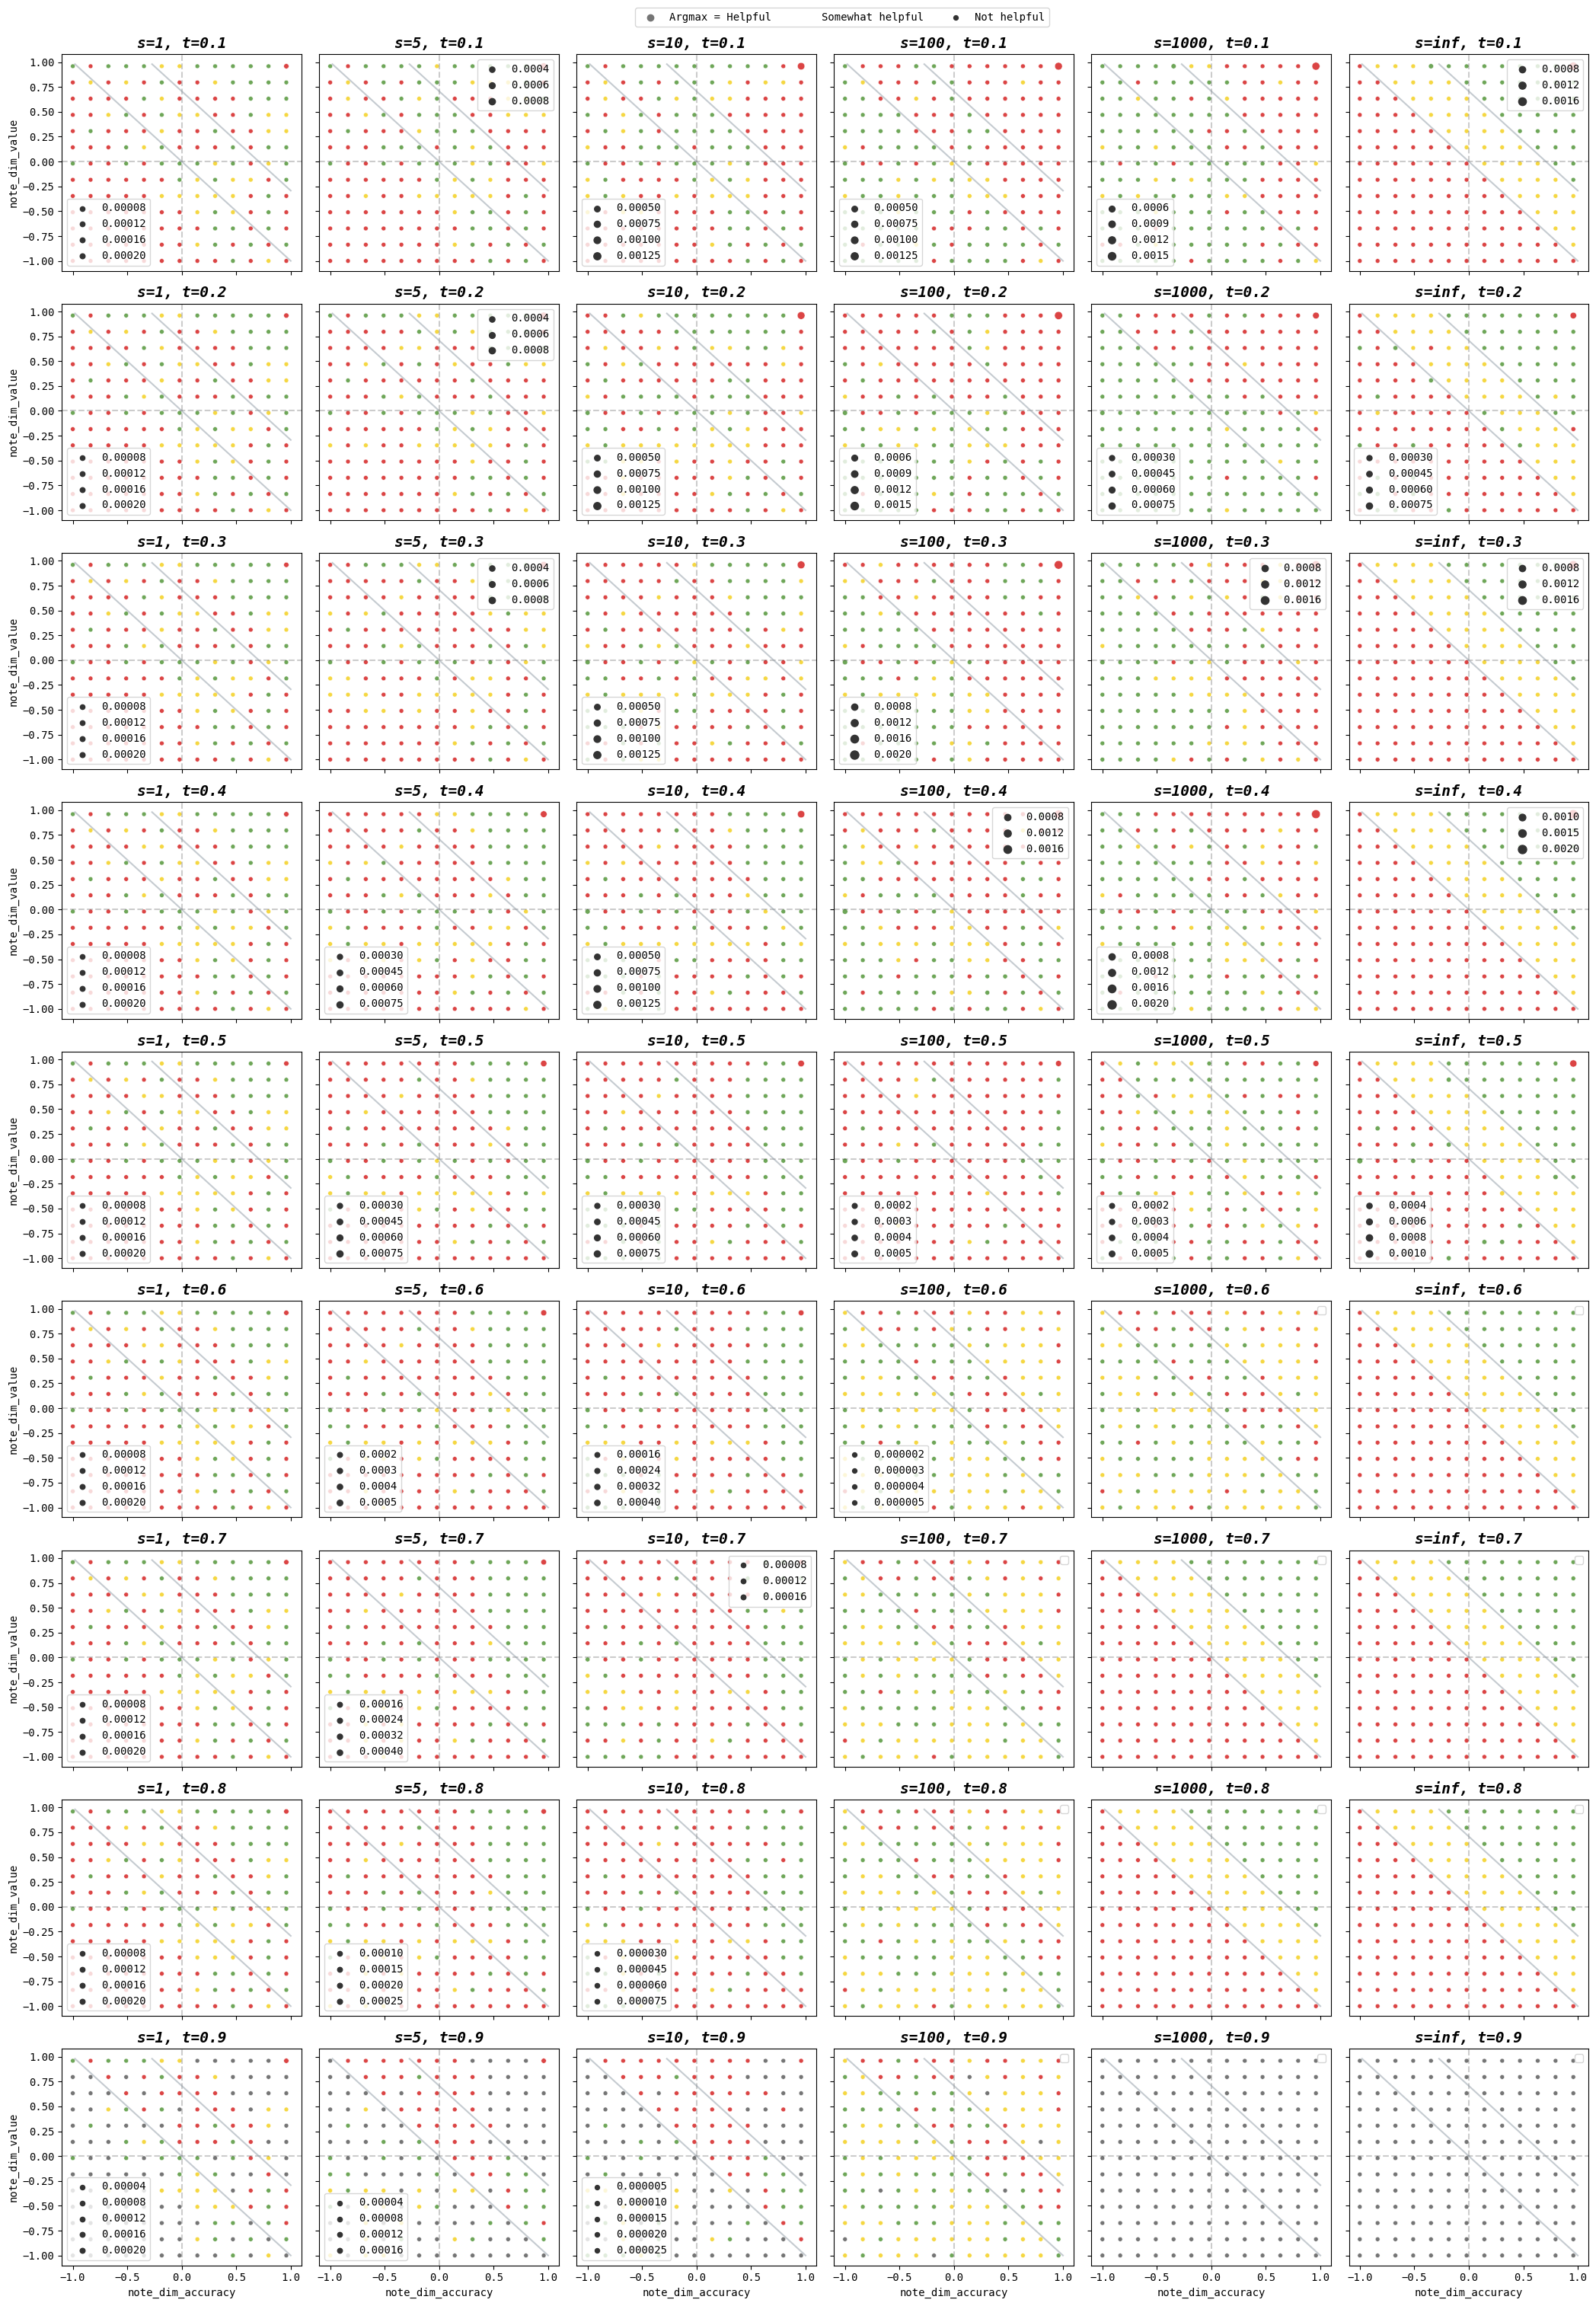

In [30]:

fig, axs = plt.subplots(9, 6, figsize=(21, 30), sharex=True, sharey=True)
size_max = max([U_a_exp[f"max_s={s}_t={t}"].max() for s in s_list for t in threshold_list])

for i, s in enumerate(s_list):
    for j, t in enumerate(threshold_list):
        ax = axs[j, i]

        s_plot = sns.scatterplot(
            data=U_a_exp, x="note_dim_accuracy", y="note_dim_value", 
            hue=f"argmax_s={s}_t={t}", palette=colors, 
            size=f"max_s={s}_t={t}", size_norm=(0, size_max),
            ax=ax, legend="brief",
        )
        s_plot.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.set_title(f's={s}, t={t}', fontdict=title_font)

        for t in [0, 0.5]:
            x = np.linspace(-1, 1, 100)
            y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
            mask = (y <= 1)

            sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5, ax=ax)
        
        h, l = s_plot.get_legend_handles_labels()
        s_plot.legend(h[7:], l[7:])

        # if i == 0:
        #     s_plot.annotate("$\\left(1-e^{s(1-d)}\\right)^{-1}$", (-1.5, 2), **{'fontsize': 12})

fig.legend(h[1:5], ["Argmax = Helpful", "Somewhat helpful", "Not helpful", "ALL"],
           loc='upper center', ncol=4, bbox_to_anchor=(0, 0.01, 1.05, 1), bbox_transform=plt.gcf().transFigure)

fig.tight_layout()
plt.show()


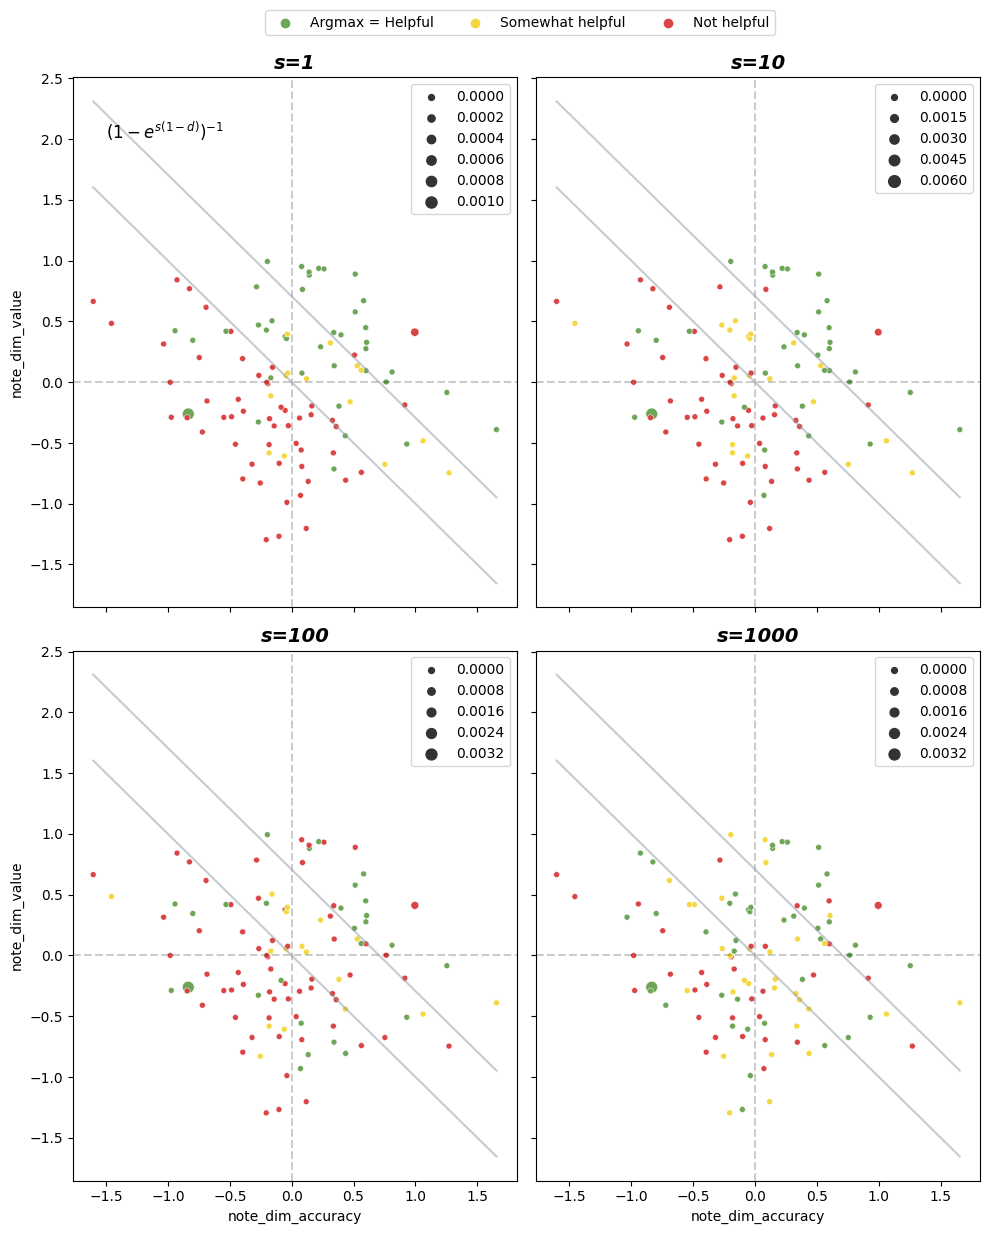

In [563]:
title_font = {
    'style': 'italic', 
    'weight': 'heavy', 
    'size': 14
    }
for s in s_list:
    for t in threshold_list:
        if s == s_list[0] and t == threshold_list[0]:
            U_a_exp = U_a.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
        else:
            U_a_exp = U_a_exp.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
    U_a_exp.loc[U_a_exp[f"max_s={s}_t={t}"] == 0, f"argmax_s={s}_t={t}"] = "ALL"

colors = {'H': '#6ea658', "S": "#f5d742", 'N': '#db4444', "ALL": "#757575"}
fig, axs = plt.subplots(2, 2, figsize=(10, 12), sharex=True, sharey=True)
x_s = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_s = 0.5/U.opinion[1] - U.opinion[0]/U.opinion[1] * x_s
x_h = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_h = - U.opinion[0]/U.opinion[1] * x_h


s1 = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue="argmax_s=1", hue_order=["H", "S", "N"], palette=colors, size="max_s=1", ax=axs[0,0], legend="brief")
s1.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
s1.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
s10 = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue="argmax_s=10", hue_order=["H", "S", "N"], palette=colors, size="max_s=10", ax=axs[0,1], legend="brief")
s10.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
s10.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
s100 = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue="argmax_s=100", hue_order=["H", "S", "N"], palette=colors, size="max_s=100", ax=axs[1,0], legend="brief")
s100.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
s100.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
s1000 = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue="argmax_s=1000", hue_order=["H", "S", "N"], palette=colors, size="max_s=1000", ax=axs[1,1], legend="brief")
s1000.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
s1000.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
s1.set_title('s=1', fontdict=title_font)
s10.set_title('s=10', fontdict=title_font)
s100.set_title('s=100', fontdict=title_font)
s1000.set_title('s=1000', fontdict=title_font)

thresh_color = "#8c98a3"
sns.lineplot(x=x_s,y=y_s, color=thresh_color, alpha=0.5, ax=axs[0,0])
sns.lineplot(x=x_s,y=y_s, color=thresh_color, alpha=0.5, ax=axs[1,0])
sns.lineplot(x=x_s,y=y_s, color=thresh_color, alpha=0.5, ax=axs[0,1])
sns.lineplot(x=x_s,y=y_s, color=thresh_color, alpha=0.5, ax=axs[1,1])
sns.lineplot(x=x_h,y=y_h, color=thresh_color, alpha=0.5, ax=axs[0,0])
sns.lineplot(x=x_h,y=y_h, color=thresh_color, alpha=0.5, ax=axs[1,0])
sns.lineplot(x=x_h,y=y_h, color=thresh_color, alpha=0.5, ax=axs[0,1])
sns.lineplot(x=x_h,y=y_h, color=thresh_color, alpha=0.5, ax=axs[1,1])

h, l = s1.get_legend_handles_labels()
s1.legend(h[5:], l[5:])
h, l = s10.get_legend_handles_labels()
s10.legend(h[5:], l[5:])
h, l = s100.get_legend_handles_labels()
s100.legend(h[5:], l[5:])
h, l = s1000.get_legend_handles_labels()
s1000.legend(h[5:], l[5:])

fig.legend(h[1:4], ["Argmax = Helpful", "Somewhat helpful", "Not helpful"], loc='upper center', ncol=3,  bbox_to_anchor = (0, 0.03, 1.05, 1), bbox_transform = plt.gcf().transFigure)
s1.annotate("$\\left(1-e^{s(1-d)}\\right)^{-1}$", (-1.5, 2), **{'fontsize': 12})

fig.tight_layout()
plt.show()

In [ ]:
est_dim_accuracy

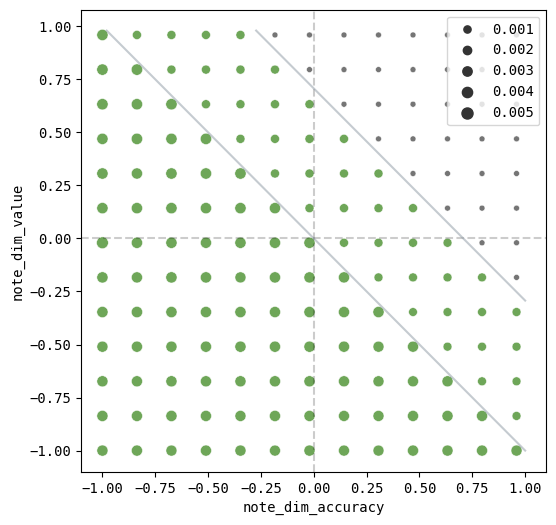

In [81]:
col = "est_dim_accuracy"
U_a_exp = U_a.merge(
    user_delta_df.loc[user_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_{col}", col: f"max_{col}", "target_note_id": "note_sim_ID"}),
    on="note_sim_ID"
)

U_a_exp.loc[U_a_exp[f"max_{col}"] == 0, f"argmax_{col}"] = "ALL"
plt.figure(figsize=(6,6))
scatter_plot = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue=f"argmax_{col}", palette=colors, size=f"max_{col}")
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

for t in [0, 0.5]:
            x = np.linspace(-1, 1, 100)
            y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
            mask = (y <= 1)

            sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5)

h, l = scatter_plot.get_legend_handles_labels()
idx = l.index(f'max_{col}') + 2
scatter_plot.legend(h[idx:], l[idx:])

plt.show()

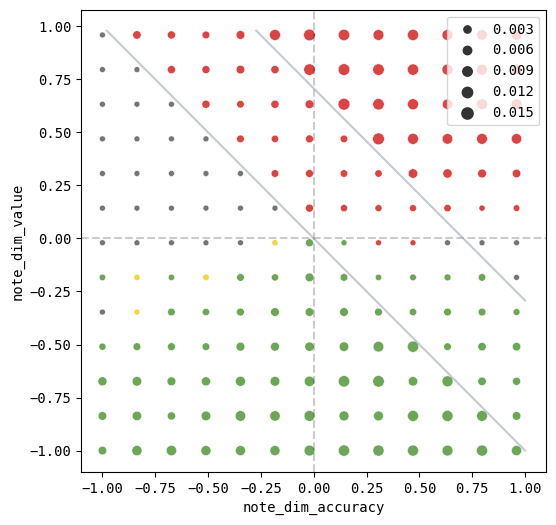

In [84]:
col = "est_dim_value"
U_a_exp = U_a.merge(
    user_delta_df.loc[user_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_{col}", col: f"max_{col}", "target_note_id": "note_sim_ID"}),
    on="note_sim_ID"
)

U_a_exp.loc[U_a_exp[f"max_{col}"] == 0, f"argmax_{col}"] = "ALL"
plt.figure(figsize=(6,6))
scatter_plot = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue=f"argmax_{col}", palette=colors, size=f"max_{col}")
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

for t in [0, 0.5]:
            x = np.linspace(-1, 1, 100)
            y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
            mask = (y <= 1)

            sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5)

h, l = scatter_plot.get_legend_handles_labels()
idx = l.index(f'max_{col}') + 2
scatter_plot.legend(h[idx:], l[idx:])

plt.show()

In [62]:
target_delta_df

experiment  target_note_id evaluation rating  dim_accuracy  \
b_4             False             4.0          N      N           0.0   
e_4_N_H          True             4.0          N      H           0.0   
b_0             False             0.0          N      N           0.0   
e_0_N_H          True             0.0          N      H           0.0   
b_24            False            24.0          N      N           0.0   
...               ...             ...        ...    ...           ...   
e_2432_H_N       True          2432.0          H      N           0.0   
e_2436_H_N       True          2436.0          H      N           0.0   
e_2448_H_N       True          2448.0          H      N           0.0   
e_2440_H_N       True          2440.0          H      N           0.0   
e_2444_H_N       True          2444.0          H      N           0.0   

            dim_value  est_dim_accuracy  est_dim_value  output  
b_4               0.0          0.000000       0.000000     0.0  
e_4_N_H           0.0          0.026944      -0.055840     0.0  
b_0               0.0          0.000000       0.000000     0.0  
e_0_N_H           0.0          0.026207      -0.056607     0.0  
b_24              0.0          0.000000       0.000000     0.0  
...               ...               ...            ...     ...  
e_2432_H_N        0.0         -0.038772       0.077953     0.0  
e_2436_H_N        0.0         -0.030645       0.065735     0.0  
e_2448_H_N        0.0         -0.020914       0.047545     0.0  
e_2440_H_N        0.0         -0.043798       0.090192     0.0  
e_2444_H_N        0.0         -0.031668       0.064405     0.0  

[507 rows x 9 columns]

In [66]:
target_delta_df

experiment  target_note_id evaluation rating  dim_accuracy  \
b_4             False             4.0          N      N           0.0   
e_4_N_H          True             4.0          N      H           0.0   
b_0             False             0.0          N      N           0.0   
e_0_N_H          True             0.0          N      H           0.0   
b_24            False            24.0          N      N           0.0   
...               ...             ...        ...    ...           ...   
e_2432_H_N       True          2432.0          H      N           0.0   
e_2436_H_N       True          2436.0          H      N           0.0   
e_2448_H_N       True          2448.0          H      N           0.0   
e_2440_H_N       True          2440.0          H      N           0.0   
e_2444_H_N       True          2444.0          H      N           0.0   

            dim_value  est_dim_accuracy  est_dim_value  output  
b_4               0.0          0.000000       0.000000     0.0  
e_4_N_H           0.0          0.026944      -0.055840     0.0  
b_0               0.0          0.000000       0.000000     0.0  
e_0_N_H           0.0          0.026207      -0.056607     0.0  
b_24              0.0          0.000000       0.000000     0.0  
...               ...               ...            ...     ...  
e_2432_H_N        0.0         -0.038772       0.077953     0.0  
e_2436_H_N        0.0         -0.030645       0.065735     0.0  
e_2448_H_N        0.0         -0.020914       0.047545     0.0  
e_2440_H_N        0.0         -0.043798       0.090192     0.0  
e_2444_H_N        0.0         -0.031668       0.064405     0.0  

[507 rows x 9 columns]

In [65]:
col = "est_dim_accuracy"
target_delta_df.loc[target_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'dim_accuracy', 'dim_value', 'rating', col]].rename(columns={"rating": f"argmax_{col}", col: f"max_{col}", "target_note_id": "note_sim_ID"})

note_sim_ID argmax_est_dim_accuracy  max_est_dim_accuracy
e_0_N_H           0.0                       H              0.026207
e_4_N_H           4.0                       H              0.026944
e_8_N_H           8.0                       H              0.030762
e_12_N_H         12.0                       H              0.025487
e_16_N_H         16.0                       H              0.023768
...               ...                     ...                   ...
b_2432         2432.0                       H              0.000000
b_2436         2436.0                       H              0.000000
b_2440         2440.0                       H              0.000000
b_2444         2444.0                       H              0.000000
b_2448         2448.0                       H              0.000000

[169 rows x 3 columns]

In [76]:
U_a[['note_sim_ID', 'note_dim_accuracy', 'note_dim_value']]

note_sim_ID  note_dim_accuracy  note_dim_value
0            0.0          -1.000000       -1.000000
1            4.0          -0.836735       -1.000000
2            8.0          -0.673469       -1.000000
3           12.0          -0.510204       -1.000000
4           16.0          -0.346939       -1.000000
..           ...                ...             ...
164       2432.0           0.306122        0.959184
165       2436.0           0.469388        0.959184
166       2440.0           0.632653        0.959184
167       2444.0           0.795918        0.959184
168       2448.0           0.959184        0.959184

[169 rows x 3 columns]

In [79]:
target_delta_df

experiment  target_note_id evaluation rating  dim_accuracy  \
b_4             False             4.0          N      N           0.0   
e_4_N_H          True             4.0          N      H           0.0   
b_0             False             0.0          N      N           0.0   
e_0_N_H          True             0.0          N      H           0.0   
b_24            False            24.0          N      N           0.0   
...               ...             ...        ...    ...           ...   
e_2432_H_N       True          2432.0          H      N           0.0   
e_2436_H_N       True          2436.0          H      N           0.0   
e_2448_H_N       True          2448.0          H      N           0.0   
e_2440_H_N       True          2440.0          H      N           0.0   
e_2444_H_N       True          2444.0          H      N           0.0   

            dim_value  est_dim_accuracy  est_dim_value  output  
b_4               0.0          0.000000       0.000000     0.0  
e_4_N_H           0.0          0.026944      -0.055840     0.0  
b_0               0.0          0.000000       0.000000     0.0  
e_0_N_H           0.0          0.026207      -0.056607     0.0  
b_24              0.0          0.000000       0.000000     0.0  
...               ...               ...            ...     ...  
e_2432_H_N        0.0         -0.038772       0.077953     0.0  
e_2436_H_N        0.0         -0.030645       0.065735     0.0  
e_2448_H_N        0.0         -0.020914       0.047545     0.0  
e_2440_H_N        0.0         -0.043798       0.090192     0.0  
e_2444_H_N        0.0         -0.031668       0.064405     0.0  

[507 rows x 9 columns]

In [77]:
target_exp

note_sim_ID  note_dim_accuracy  note_dim_value argmax_output_s=1_t=0.1  \
0            0.0          -1.000000       -1.000000                       H   
1            4.0          -0.836735       -1.000000                       H   
2            8.0          -0.673469       -1.000000                       H   
3           12.0          -0.510204       -1.000000                       H   
4           16.0          -0.346939       -1.000000                       H   
..           ...                ...             ...                     ...   
164       2432.0           0.306122        0.959184                     ALL   
165       2436.0           0.469388        0.959184                     ALL   
166       2440.0           0.632653        0.959184                     ALL   
167       2444.0           0.795918        0.959184                     ALL   
168       2448.0           0.959184        0.959184                     ALL   

     max_output_s=1_t=0.1  
0                0.006529  
1                0.006728  
2                0.007670  
3                0.006361  
4                0.005935  
..                    ...  
164              0.000000  
165              0.000000  
166              0.000000  
167              0.000000  
168              0.000000  

[169 rows x 5 columns]

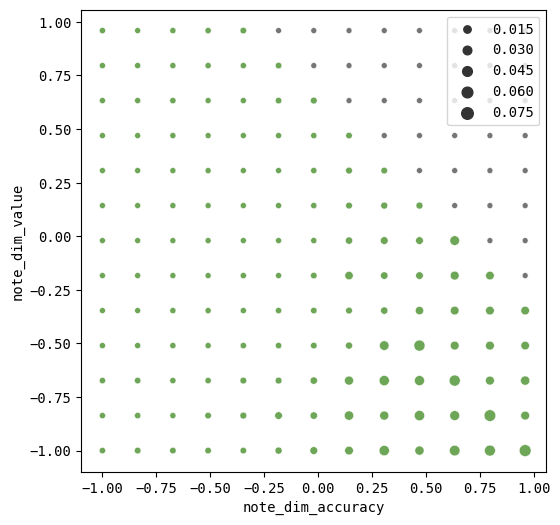

In [87]:
col = "output_s=10_t=0.4"
target_exp = U_a[['note_sim_ID', 'note_dim_accuracy', 'note_dim_value']].merge(
    target_delta_df.loc[target_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_{col}", col: f"max_{col}", "target_note_id": "note_sim_ID"}),
    on="note_sim_ID")
target_exp.loc[target_exp[f"max_{col}"] == 0, f"argmax_{col}"] = "ALL"

plt.figure(figsize=(6,6))
scatter_plot = sns.scatterplot(target_exp, x="note_dim_accuracy", y="note_dim_value", hue=f"argmax_{col}", palette=colors, size=f"max_{col}")

h, l = scatter_plot.get_legend_handles_labels()
idx = l.index(f'max_{col}') + 2
scatter_plot.legend(h[idx:], l[idx:])

plt.show()

In [93]:
col

'output_s=10_t=0.4'

In [90]:
for s in s_list:
    for t in threshold_list:
        if s == s_list[0] and t == threshold_list[0]:
            target_exp = U_a[['note_sim_ID', 'note_dim_accuracy', 'note_dim_value']].merge(
                target_delta_df.loc[target_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_s={s}_t={t}", col: f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
                )
        else:
            target_exp = target_exp.merge(
                target_delta_df.loc[target_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_s={s}_t={t}", col: f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
    target_exp.loc[target_exp[f"max_s={s}_t={t}"] == 0, f"argmax_s={s}_t={t}"] = "ALL"

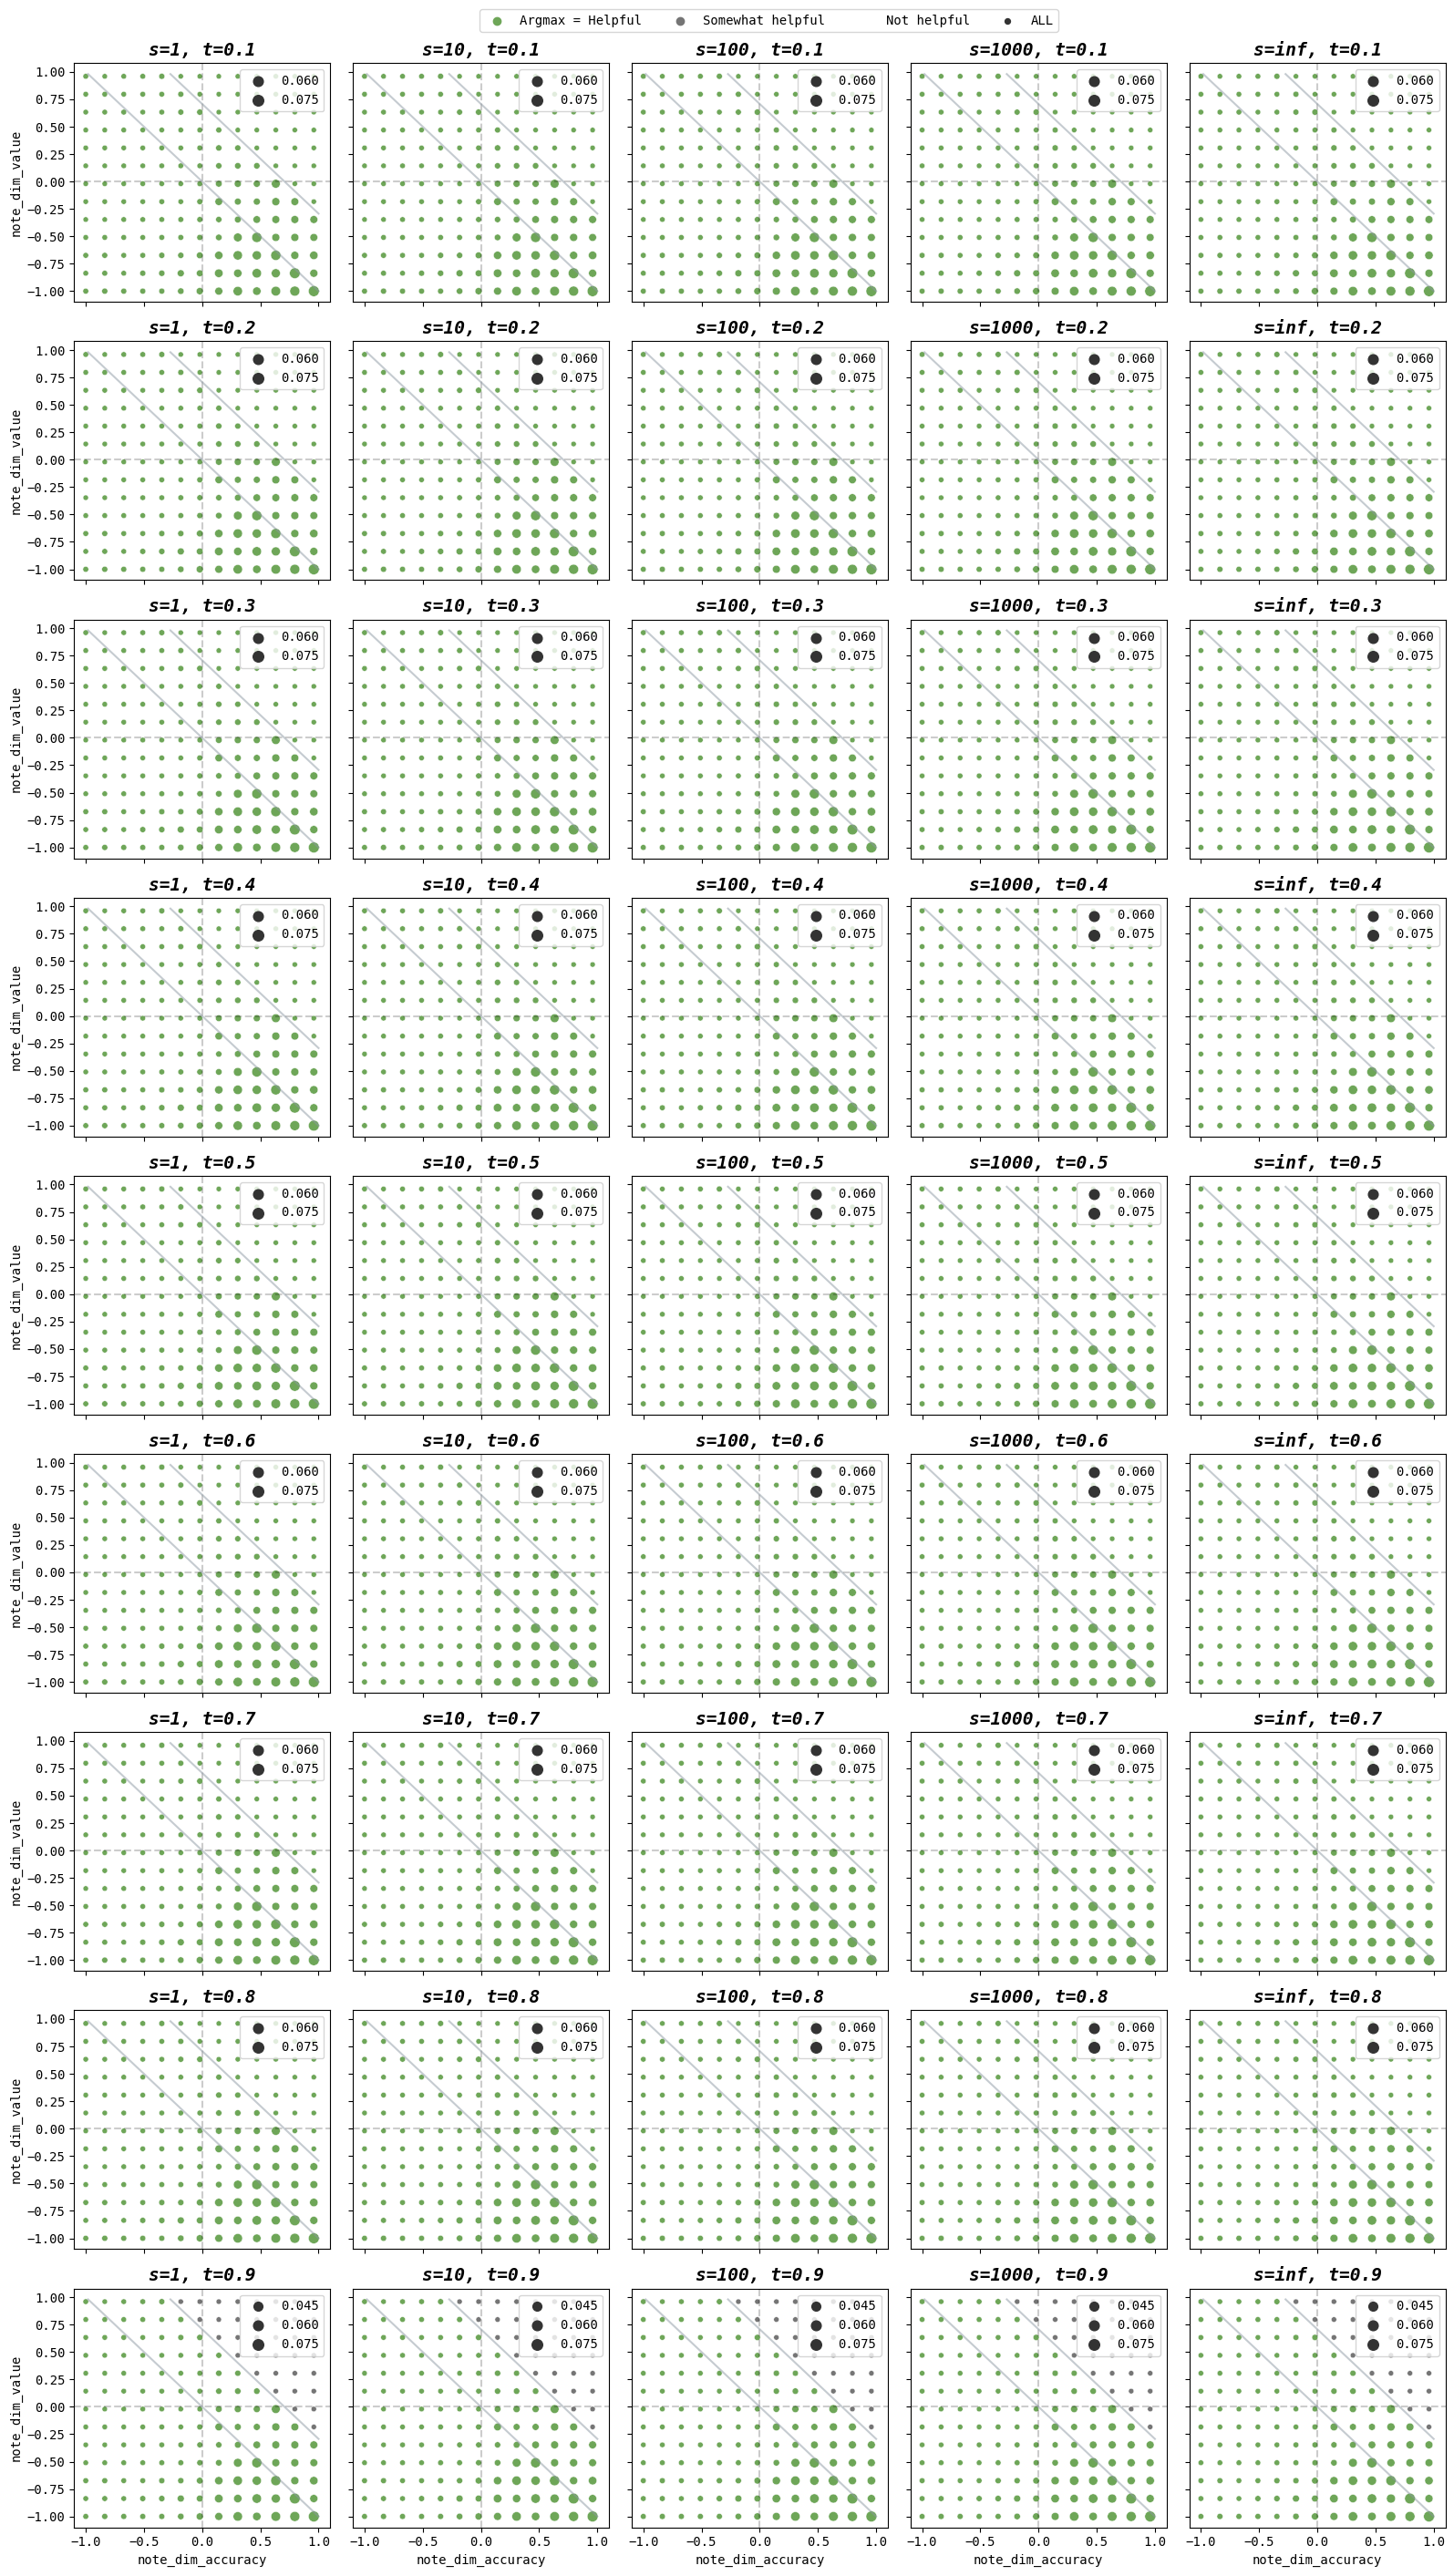

In [97]:

fig, axs = plt.subplots(9, 5, figsize=(16, 28), sharex=True, sharey=True)
size_max = max([target_exp[f"max_s={s}_t={t}"].max() for s in s_list for t in threshold_list])

for i, s in enumerate(s_list):
    for j, t in enumerate(threshold_list):
        ax = axs[j, i]

        s_plot = sns.scatterplot(
            data=target_exp, x="note_dim_accuracy", y="note_dim_value", 
            hue=f"argmax_s={s}_t={t}", palette=colors, 
            size=f"max_s={s}_t={t}", size_norm=(0, size_max),
            ax=ax, legend="brief",
        )
        s_plot.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.set_title(f's={s}, t={t}', fontdict=title_font)

        for t in [0, 0.5]:
            x = np.linspace(-1, 1, 100)
            y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
            mask = (y <= 1)

            sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5, ax=ax)
        
        h, l = s_plot.get_legend_handles_labels()
        s_plot.legend(h[7:], l[7:])

        # if i == 0:
        #     s_plot.annotate("$\\left(1-e^{s(1-d)}\\right)^{-1}$", (-1.5, 2), **{'fontsize': 12})

fig.legend(h[1:5], ["Argmax = Helpful", "Somewhat helpful", "Not helpful", "ALL"],
           loc='upper center', ncol=4, bbox_to_anchor=(0, 0.01, 1.05, 1), bbox_transform=plt.gcf().transFigure)

fig.tight_layout()
plt.show()


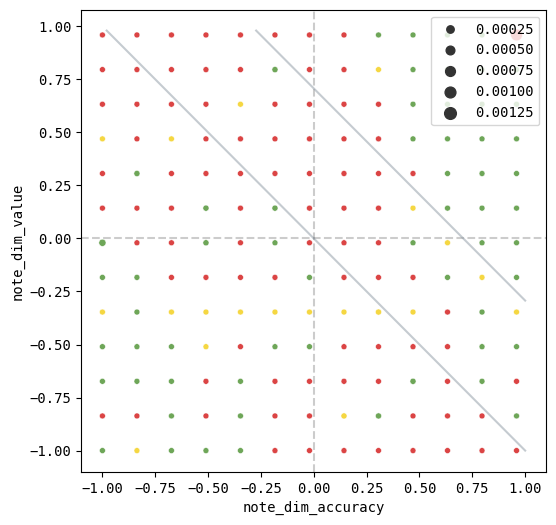

In [57]:
col = "output_dot_s=10_t=0.4"
U_a_exp = U_a.merge(
    user_delta_df.loc[user_delta_df.groupby('target_note_id')[col].idxmax()][['target_note_id', 'rating', col]].rename(columns={"rating": f"argmax_{col}", col: f"max_{col}", "target_note_id": "note_sim_ID"}),
    on="note_sim_ID"
)
plt.figure(figsize=(6,6))
scatter_plot = sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue=f"argmax_{col}", palette=colors, size=f"max_{col}")
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

for t in [0, 0.5]:
            x = np.linspace(-1, 1, 100)
            y = t/U.opinion[1] - U.opinion[0]/U.opinion[1] * x
            mask = (y <= 1)

            sns.lineplot(x=x[mask],y=y[mask], color=thresh_color, alpha=0.5)

h, l = scatter_plot.get_legend_handles_labels()
idx = l.index(f'max_{col}') + 2
scatter_plot.legend(h[idx:], l[idx:])

plt.show()

In [ ]:
for s in s_list:
    for t in threshold_list:
        if s == s_list[0] and t == threshold_list[0]:
            U_a_exp = U_a.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
        else:
            U_a_exp = U_a_exp.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
    U_a_exp.loc[U_a_exp[f"max_s={s}_t={t}"] == 0, f"argmax_s={s}_t={t}"] = "ALL"

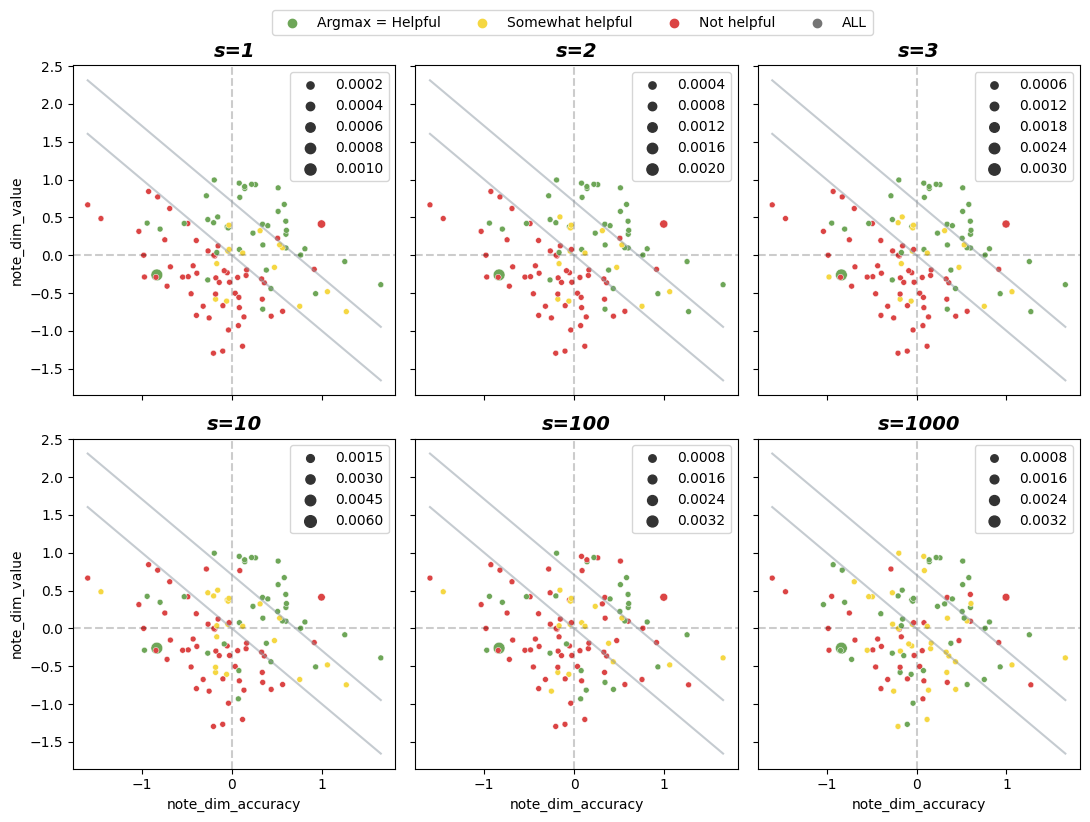

In [604]:
for s in s_list:
    for t in threshold_list:
        if s == s_list[0] and t == threshold_list[0]:
            U_a_exp = U_a.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
        else:
            U_a_exp = U_a_exp.merge(
                user_delta_df.loc[user_delta_df.groupby('target_note_id')[f'output_dot_s={s}_t={t}'].idxmax()][['target_note_id', 'rating', f'output_dot_s={s}_t={t}']].rename(columns={"rating": f"argmax_s={s}_t={t}", f"output_dot_s={s}_t={t}": f"max_s={s}_t={t}", "target_note_id": "note_sim_ID"}),
                on="note_sim_ID"
            )
    U_a_exp.loc[U_a_exp[f"max_s={s}_t={t}"] == 0, f"argmax_s={s}_t={t}"] = "ALL"
        
title_font = {
    'style': 'italic',
    'weight': 'heavy',
    'size': 14
}

colors = {'H': '#6ea658', "S": "#f5d742", 'N': '#db4444', "ALL": "#757575"}

fig, axs = plt.subplots(2, 3, figsize=(11, 8), sharex=True, sharey=True)

x_s = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_s = 0.5/U.opinion[1] - U.opinion[0]/U.opinion[1] * x_s
x_h = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_h = - U.opinion[0]/U.opinion[1] * x_h

for i, s in enumerate(s_list[:-1]):
    ax = axs[i // 3, i % 3]
    scatter_data = U_a_exp
    col_prefix = f"argmax_s={s}_t=0.4"

    s_plot = sns.scatterplot(
        data=scatter_data, x="note_dim_accuracy", y="note_dim_value", hue=col_prefix,
        hue_order=["H", "S", "N", "ALL"], palette=colors, size=f"max_s={s}_t=0.4", ax=ax, legend="brief"
    )
    s_plot.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
    s_plot.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
    s_plot.set_title(f's={s}', fontdict=title_font)
    
    sns.lineplot(x=x_s, y=y_s, color=thresh_color, alpha=0.5, ax=ax)
    sns.lineplot(x=x_h, y=y_h, color=thresh_color, alpha=0.5, ax=ax)
    
    h, l = s_plot.get_legend_handles_labels()
    s_plot.legend(h[7:], l[7:])

    # if i == 0:
    #     s_plot.annotate("$\\left(1-e^{s(1-d)}\\right)^{-1}$", (-1.5, 2), **{'fontsize': 12})

fig.legend(h[1:5], ["Argmax = Helpful", "Somewhat helpful", "Not helpful", "ALL"],
           loc='upper center', ncol=4, bbox_to_anchor=(0, 0.03, 1.05, 1), bbox_transform=plt.gcf().transFigure)

fig.tight_layout()
plt.show()


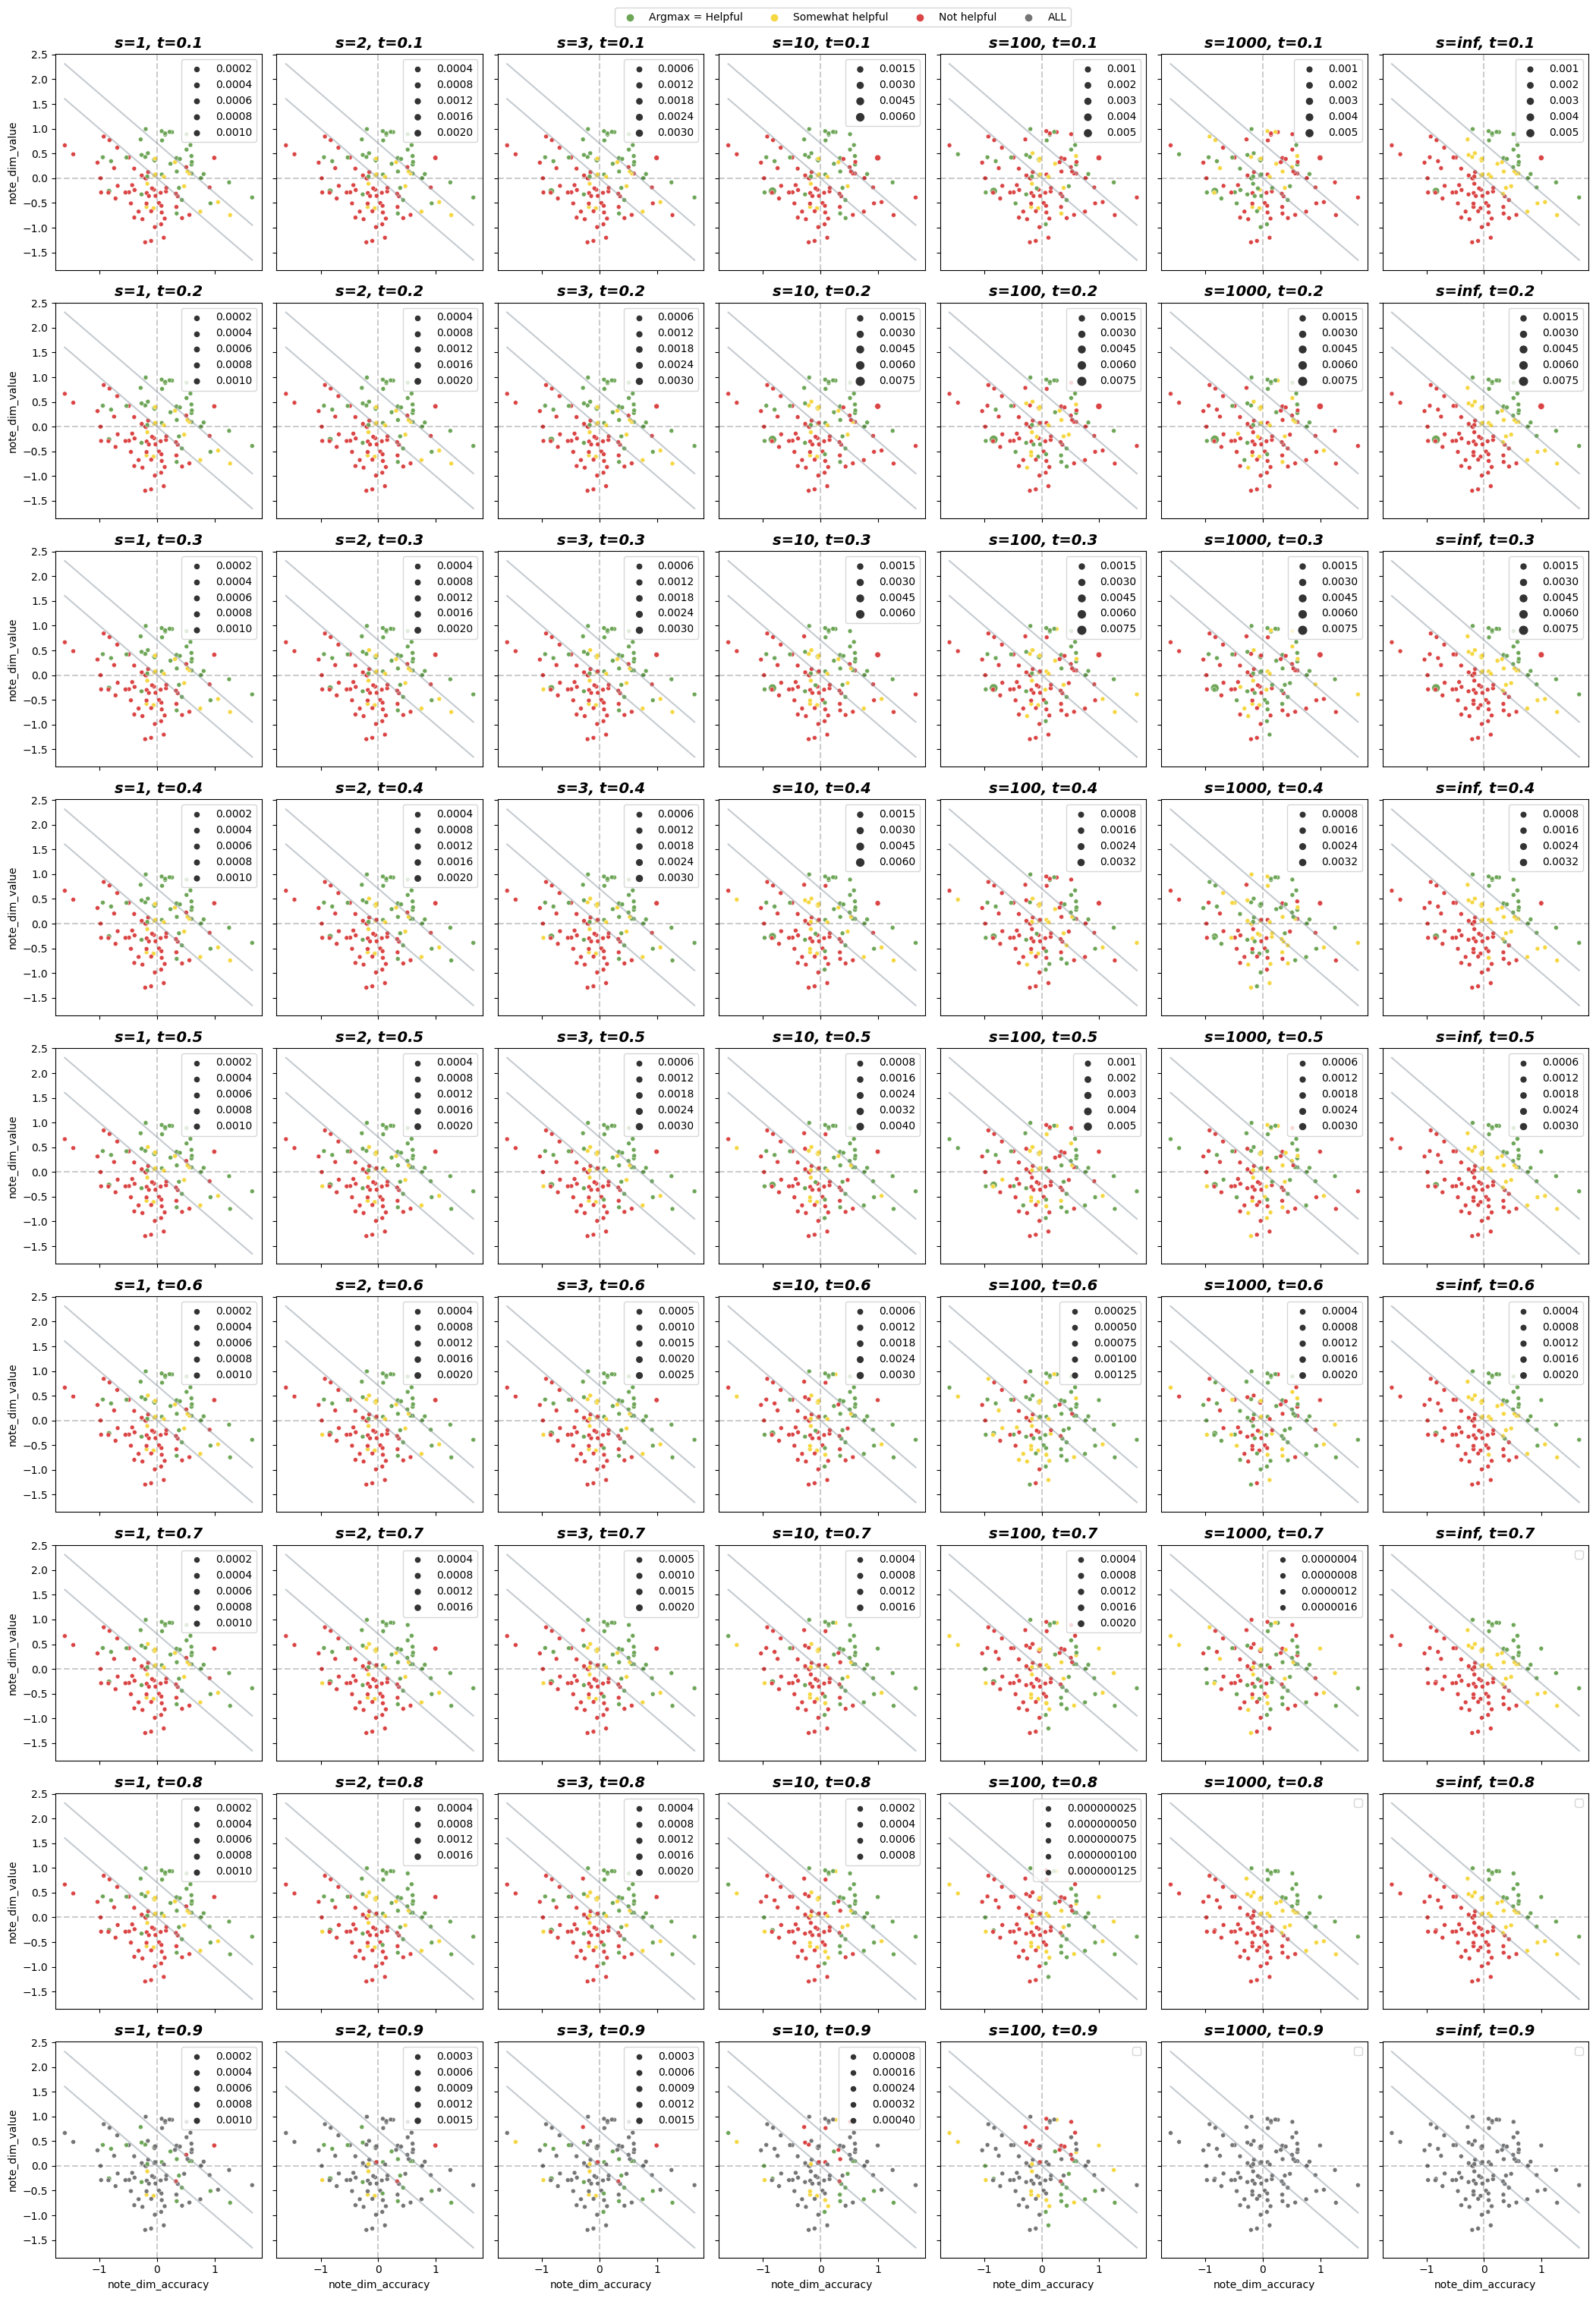

In [620]:
title_font = {
    'style': 'italic',
    'weight': 'heavy',
    'size': 14
}

colors = {'H': '#6ea658', "S": "#f5d742", 'N': '#db4444', "ALL": "#757575"}

fig, axs = plt.subplots(9, 7, figsize=(21, 30), sharex=True, sharey=True)

x_s = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_s = 0.5/U.opinion[1] - U.opinion[0]/U.opinion[1] * x_s
x_h = np.linspace(U_a_exp['note_dim_accuracy'].min(), U_a_exp['note_dim_accuracy'].max(), 10)
y_h = - U.opinion[0]/U.opinion[1] * x_h

for i, s in enumerate(s_list):
    for j, t in enumerate(threshold_list):
        ax = axs[j, i]
        scatter_data = U_a_exp
        col_prefix = f"argmax_s={s}_t={t}"

        s_plot = sns.scatterplot(
            data=scatter_data, x="note_dim_accuracy", y="note_dim_value", hue=col_prefix,
            hue_order=["H", "S", "N", "ALL"], palette=colors, size=f"max_s={s}_t={t}", ax=ax, legend="brief", size_norm=(0, 0.01)
        )
        s_plot.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
        s_plot.set_title(f's={s}, t={t}', fontdict=title_font)
        
        sns.lineplot(x=x_s, y=y_s, color=thresh_color, alpha=0.5, ax=ax)
        sns.lineplot(x=x_h, y=y_h, color=thresh_color, alpha=0.5, ax=ax)
        
        h, l = s_plot.get_legend_handles_labels()
        s_plot.legend(h[7:], l[7:])

        # if i == 0:
        #     s_plot.annotate("$\\left(1-e^{s(1-d)}\\right)^{-1}$", (-1.5, 2), **{'fontsize': 12})

fig.legend(h[1:5], ["Argmax = Helpful", "Somewhat helpful", "Not helpful", "ALL"],
           loc='upper center', ncol=4, bbox_to_anchor=(0, 0.01, 1.05, 1), bbox_transform=plt.gcf().transFigure)

fig.tight_layout()
plt.show()


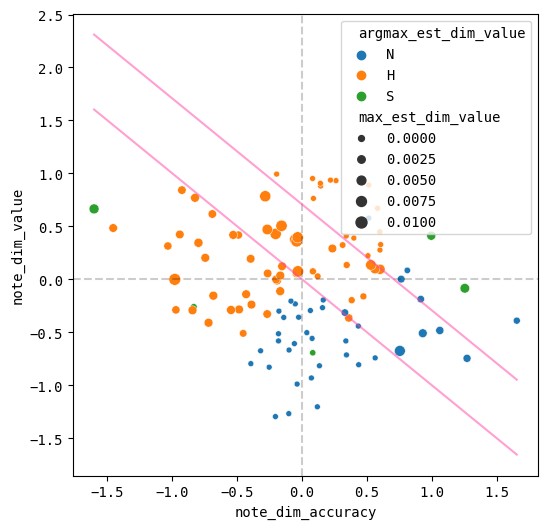

In [375]:
U_a_exp = U_a.merge(
    user_delta_df.loc[user_delta_df.groupby('target_note_id')['est_dim_value'].idxmax()][['target_note_id', 'rating', 'est_dim_value']].rename(columns={"rating": "argmax_est_dim_value", "est_dim_value": "max_est_dim_value", "target_note_id": "note_sim_ID"}),
    on="note_sim_ID"
)
plt.figure(figsize=(6,6))
sns.scatterplot(U_a_exp, x="note_dim_accuracy", y="note_dim_value", hue="argmax_est_dim_value", size="max_est_dim_value")
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

x = np.linspace(U_a['note_dim_accuracy'].min(), U_a['note_dim_accuracy'].max(), 10)
y = 0.5/U.opinion[1] - U.opinion[0]/U.opinion[1] * x

sns.lineplot(x=x,y=y, color="#ff42a4", alpha=0.5)

x = np.linspace(U_a['note_dim_accuracy'].min(), U_a['note_dim_accuracy'].max(), 10)
y = - U.opinion[0]/U.opinion[1] * x

sns.lineplot(x=x,y=y, color="#ff42a4", alpha=0.5)

plt.show()

In [ ]:
ratings_list = ["HELPFUL", "SOMEWHAT_HELPFUL", "NOT_HELPFUL"]
ratings_dict = {"HELPFUL": "H", "SOMEWHAT_HELPFUL": "S", "NOT_HELPFUL": "N"}
point_experiment_index = np.where(a['user_sim_ID'] == U.sim_id)[0]

a_H = a.loc[point_experiment_index]
a_H['rating'] = 1
a_S = a.loc[point_experiment_index]
a_S['rating'] = 0.5
a_N = a.loc[point_experiment_index]
a_N['rating'] = 0
rating_input_df = generate_ratings_data(pd.concat([a, a_H, a_S, a_N]), Sim, return_data = True)
input_df_dict = {
    'baseline': rating_input_df.iloc[:len(a),:],
    "HELPFUL": rating_input_df.iloc[len(a):len(a) + len(a_H),:],
    "SOMEWHAT_HELPFUL": rating_input_df.iloc[len(a) + len(a_H):len(a) + len(a_H) + len(a_S),:],
    "NOT_HELPFUL": rating_input_df.iloc[len(a) + len(a_H) + len(a_S):,:],
}
experiment_ratings = {"baseline": a}
filenames = {"baseline": os.path.join(C.exp_data_path, "baseline.tsv")}
input_df_dict['baseline'].to_csv(filenames["baseline"], sep="\t", index=False)
for enum, idx in enumerate(point_experiment_index):
    this_rating = a.copy()
    exp_note_ID = this_rating.iloc[idx]['note_sim_ID'].astype(int)
    exp_eval = this_rating.iloc[idx]['evaluation']
    for r in ratings_list:
        if r != exp_eval:
            this_rating.loc[idx, 'rating'] = r
            experiment_ratings[experiment_name] = this_rating

            experiment_name = f"e_{exp_note_ID}_{ratings_dict[exp_eval]}_{ratings_dict[r]}"
            filename = os.path.join(C.exp_data_path, f"{experiment_name}.tsv")
            filename[experiment_name] = filename
            
            input_df = input_df_dict['baseline'].copy()
            input_df.loc[idx, :] = input_df_dict[r].iloc[enum]
            input_df.to_csv(filename, sep="\t", index=False)

In [ ]:
U_a_index = np.where(a['user_sim_ID'] == U.sim_id)[0]
U_a = a.iloc[U_a_index,:]
plt.figure(figsize=(6,6))
sns.scatterplot(U_a, x="note_dim_accuracy", y="note_dim_value", hue="evaluation")
plt.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
plt.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")

for i in range(U_a.shape[0]):
    plt.annotate(U_a['note_sim_ID'].iloc[i].astype(int), (U_a['note_dim_accuracy'].iloc[i], U_a['note_dim_value'].iloc[i]), **{'fontsize': 7})

x = np.linspace(U_a['note_dim_accuracy'].min(), U_a['note_dim_accuracy'].max(), 10)
y = 0.5/U.opinion[1] - U.opinion[0]/U.opinion[1] * x

sns.lineplot(x=x,y=y, color="#ff42a4", alpha=0.5)

x = np.linspace(U_a['note_dim_accuracy'].min(), U_a['note_dim_accuracy'].max(), 10)
y = - U.opinion[0]/U.opinion[1] * x

sns.lineplot(x=x,y=y, color="#ff42a4", alpha=0.5)

plt.show()
zones = {
    "zone1": U_a.iloc[np.where((U_a['note_dim_value'] >= 0) & (U_a['note_dim_accuracy'] < 0) & (U_a['evaluation'] == "NOT_HELPFUL"))[0],:].index,
    "zone2": U_a.iloc[np.where((U_a['note_dim_value'] >= 0) & (U_a['note_dim_accuracy'] < 0) & (U_a['evaluation'] == "SOMEWHAT_HELPFUL"))[0],:].index,
    "zone3": U_a.iloc[np.where((U_a['note_dim_value'] >= 0) & (U_a['note_dim_accuracy'] < 0) & (U_a['evaluation'] == "HELPFUL"))[0],:].index,
    "zone4": U_a.iloc[np.where((U_a['note_dim_value'] < 0) & (U_a['note_dim_accuracy'] < 0))[0],:].index,
    "zone5": U_a.iloc[np.where((U_a['note_dim_value'] >= 0) & (U_a['note_dim_accuracy'] >= 0) & (U_a['evaluation'] == "SOMEWHAT_HELPFUL"))[0],:].index,
    "zone6": U_a.iloc[np.where((U_a['note_dim_value'] >= 0) & (U_a['note_dim_accuracy'] >= 0) & (U_a['evaluation'] == "HELPFUL"))[0],:].index,
    "zone7": U_a.iloc[np.where((U_a['note_dim_value'] < 0) & (U_a['note_dim_accuracy'] >= 0) & (U_a['evaluation'] == "NOT_HELPFUL"))[0],:].index,
    "zone8": U_a.iloc[np.where((U_a['note_dim_value'] < 0) & (U_a['note_dim_accuracy'] >= 0) & (U_a['evaluation'] == "SOMEWHAT_HELPFUL"))[0],:].index,
    "zone9": U_a.iloc[np.where((U_a['note_dim_value'] < 0) & (U_a['note_dim_accuracy'] >= 0) & (U_a['evaluation'] == "HELPFUL"))[0],:].index,
}
a['zones'] = ""
for k in zones.keys():
    a.loc[zones[k], 'zones'] = k
a['rating'] = a['evaluation']

In [ ]:
generate_ratings_data(a, Sim)
run_main()
note_input_output, user_input_output = factorization_results(Sim, a)
experiment_input_output = experiment_concat(U, a, user_input_output, note_input_output, strategy_label="baseline")

In [ ]:
generate_ratings_data(a_str1, Sim)
run_main()
note_input_output, user_input_output = factorization_results(Sim, a_str1)
experiment_input_output = experiment_concat(U, a_str1, user_input_output, note_input_output, strategy_label=str1_label, experiment_input_output=experiment_input_output)

In [ ]:
generate_ratings_data(a_str2, Sim)
run_main()
note_input_output, user_input_output = factorization_results(Sim, a_str2)
experiment_input_output = experiment_concat(U, a_str2, user_input_output, note_input_output, strategy_label=str2_label, experiment_input_output=experiment_input_output)

In [ ]:
generate_ratings_data(a_str3, Sim)
run_main()
note_input_output, user_input_output = factorization_results(Sim, a_str3)
experiment_input_output = experiment_concat(U, a_str3, user_input_output, note_input_output, strategy_label='strategy3', experiment_input_output=experiment_input_output)

In [ ]:
strategy_comp = experiment_input_output[['note_sim_ID', 'note_est_dim_accuracy', 'note_est_dim_value', 'output', 'strategy', 'zones']].pivot_table(index=['note_sim_ID', 'zones'], columns='strategy', values=['output', 'note_est_dim_accuracy', 'note_est_dim_value']).reset_index()
strategy_comp['str1_outcome_diff'] = strategy_comp[('output', str1_label)] - strategy_comp[('output', 'baseline')]
strategy_comp['str1_dim_accuracy_diff'] = strategy_comp[('note_est_dim_accuracy', str1_label)] - strategy_comp[('note_est_dim_accuracy', 'baseline')]
strategy_comp['str1_dim_value_diff'] = strategy_comp[('note_est_dim_value', str1_label)] - strategy_comp[('note_est_dim_value', 'baseline')]

strategy_comp['str2_outcome_diff'] = strategy_comp[('output', str2_label)] - strategy_comp[('output', 'baseline')]
strategy_comp['str2_dim_accuracy_diff'] = strategy_comp[('note_est_dim_accuracy', str2_label)] - strategy_comp[('note_est_dim_accuracy', 'baseline')]
strategy_comp['str2_dim_value_diff'] = strategy_comp[('note_est_dim_value', str2_label)] - strategy_comp[('note_est_dim_value', 'baseline')]

str3_label2 = 'strategy3'
strategy_comp['str3_outcome_diff'] = strategy_comp[('output', str3_label2)] - strategy_comp[('output', 'baseline')]
strategy_comp['str3_dim_accuracy_diff'] = strategy_comp[('note_est_dim_accuracy', str3_label2)] - strategy_comp[('note_est_dim_accuracy', 'baseline')]
strategy_comp['str3_dim_value_diff'] = strategy_comp[('note_est_dim_value', str3_label2)] - strategy_comp[('note_est_dim_value', 'baseline')]
strategy_comp

In [ ]:
strategy_comp['str3_outcome_diff'].value_counts()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
baseline = sns.scatterplot(data=experiment_input_output.loc[experiment_input_output['strategy'] == "baseline",:], x='note_dim_accuracy', y='note_dim_value', hue="output", ax=axs[0])
str1 = sns.scatterplot(data=experiment_input_output.loc[experiment_input_output['strategy'] == str1_label,:], x='note_dim_accuracy', y='note_dim_value', hue="output", ax=axs[1], legend=False)
str1 = sns.scatterplot(data=experiment_input_output.loc[experiment_input_output['strategy'] == str2_label,:], x='note_dim_accuracy', y='note_dim_value', hue="output", ax=axs[2], legend=False)
fig.tight_layout()

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
strategy_comp_to_plot = strategy_comp[strategy_comp['zones'].isin(['zone2', 'zone3', 'zone5', 'zone6', 'zone8', 'zone9'])]

str1 = sns.scatterplot(data=strategy_comp_to_plot, x='str1_dim_accuracy_diff', y='str1_dim_value_diff', hue="zones", ax=axs[0, 0], legend=False)
title_font = {'style': 'italic',
                    'weight': 'heavy', 
                    'size': 9}
str1.set_title('Strategy 1', fontdict=title_font)
str2 = sns.scatterplot(data=strategy_comp_to_plot, x='str2_dim_accuracy_diff', y='str2_dim_value_diff', hue="zones", ax=axs[0, 1], legend=False)
str2.set_title('Strategy 2', fontdict=title_font)
str3 = sns.scatterplot(data=strategy_comp_to_plot, x='str3_dim_accuracy_diff', y='str3_dim_value_diff', hue="zones", ax=axs[1, 0], legend='auto')
str3.set_title('Strategy 3', fontdict=title_font)

str1.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
str1.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
str2.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
str2.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
str3.axhline(y=0, color='black', alpha=0.2, linestyle="dashed")
str3.axvline(x=0, color='black', alpha=0.2, linestyle="dashed")
fig.tight_layout()

plt.show()

In [ ]:
experiment_input_output

In [ ]:
def plot_user_location(strategic_id, user_input_output, experiment_input_output):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
    cmap = plt.cm.get_cmap('cool')

    non_strategic = user_input_output.loc[user_input_output["user_sim_ID"] != strategic_id,:]
    num_experiment = experiment_input_output.shape[0]

    accuracy = sns.scatterplot(data=non_strategic, x="dim_accuracy", y="est_dim_accuracy", c='pink', alpha=0.5, label='other players', ax=axs[0], legend=False)
    value = sns.scatterplot(data=non_strategic, x="dim_value", y="est_dim_value", c='pink', alpha=0.5, label='other players', ax=axs[1], legend='auto')

    for i in range(num_experiment):
        color = cmap(i / (num_experiment))
        this_exp = experiment_input_output.iloc[i,:]
        strategy = this_exp["strategy"]
        
        axs[0].scatter(x=[this_exp["dim_accuracy"]], y=[this_exp["est_dim_accuracy"]], c=[color], label=strategy, zorder=10)
        axs[1].scatter(x=[this_exp["dim_value"]], y=[this_exp["est_dim_value"]], c=[color], label=strategy, zorder=10)

    x = np.linspace(user_input_output['est_dim_value'].min(), user_input_output['est_dim_value'].max(), 10)
    sns.lineplot(x=x, y=x, color="#ff42a4", alpha=0.5, label='45 degree line', ax=axs[1])
    
    sns.move_legend(value, loc='upper right', bbox_to_anchor=(1, .24), ncols=1)
    value.set(xlabel='True value dimension', ylabel='Estimated value dimension')
    value.yaxis.tick_right()
    value.yaxis.set_label_position("right")
    accuracy.set(xlabel='True accuracy dimension', ylabel='Estimated accuracy dimension')

    fig.tight_layout()

    plt.show()

plot_user_location(U.sim_id, user_input_output, experiment_input_output)


In [ ]:
user_input_output

In [ ]:
user_input_output[["raterAgreeRatio", "crhCrnhRatioDifference", "meanNoteScore", "aboveHelpfulnessThreshold"]].describe()

In [ ]:
user_input_output['raterAgreeRatio'].describe()